### Targeted lipidomics analysis of Pancreas Tissue using LC-MS
#### Comparison is healthy donors, type 1 diabetes donors and type 2 diabetes donors 
###### Details regarding sample groups can be found in README

In [98]:
### Import necessary libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib.patches import Ellipse
from matplotlib import transforms

import seaborn as sns
import scipy as sp

import sklearn as sk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score        
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

import shap

In [37]:
### Loading lipidomics dataset into pandas df

# Load dataset
lipidomicsDF = pd.read_csv('lipidomicsdatafinal.csv')

# Create a deep copy for analysis
lipidomicsRawAnalysisDf = lipidomicsDF.copy()

# Quick inspection of data types and nulls
lipidomicsRawAnalysisDf.head()

# Make SampleID the index
lipidomicsRawAnalysisDf.set_index('Samples', inplace=True)

# print(lipidomicsRawAnalysisDf.head)
# Statistical summary
# lipidomicsRawAnalysisDf.describe()

In [38]:
# How many zero values are in each column/lipid species

# Count zeros for each column (lipids)
zeroCountsLipids = (lipidomicsRawAnalysisDf == 0.0).sum()

# Count zeros for each row (donors/samples)
zeroCountsDonors = (lipidomicsRawAnalysisDf == 0.0).sum(axis=1)

# Create DataFrame with donor names, zero counts, and percentage
totalLipids = lipidomicsRawAnalysisDf.shape[1]  # Total number of columns (lipids)

zeroCountsDonorsDf = pd.DataFrame({
    'Samples': lipidomicsRawAnalysisDf.index,
    'ZeroCount': zeroCountsDonors.values,
    'ZeroPercentage': (zeroCountsDonors.values / totalLipids) * 100
})

# Similarly for lipids
totalDonors = lipidomicsRawAnalysisDf.shape[0]  # Total number of rows (donors)

zeroCountsLipidsDf = pd.DataFrame({
    'Lipid': zeroCountsLipids.index,
    'ZeroCount': zeroCountsLipids.values,
    'ZeroPercentage': (zeroCountsLipids.values / totalDonors) * 100
})

# Display first 40 entries of each
# zeroCountsLipidsDf.head(40)
zeroCountsDonorsDf.head(40)


,Samples,ZeroCount,ZeroPercentage
0,651_CR,31,10.689655
1,668_C,29,10.000000
2,671_C,26,8.965517
3,674_CR,26,8.965517
4,677_B,25,8.620690
5,679_CR,34,11.724138
6,682_B,27,9.310345
7,685_BR,32,11.034483
8,687_B,29,10.000000
9,690_B,23,7.931034


In [39]:
# Here we are looking for number of "Technical Nulls" (NaNs), not "Numerical Nulls" (Zeros).

# This scans every single cell in your DataFrame. If a cell contains a missing value (like NaN or None), it marks it as True. 
# If it contains a number (even 0), it marks it as False. 
# The first .sum() counts the number of True values in each individual column. 
# The second .sum() adds all those column totals together to give you one single integer representing every missing data point in the entire table

lipidIsNullMissing = lipidomicsRawAnalysisDf.isnull().sum().sum()
if lipidIsNullMissing == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"Total missing values: {lipidIsNullMissing}")

There are no missing values in the dataset.


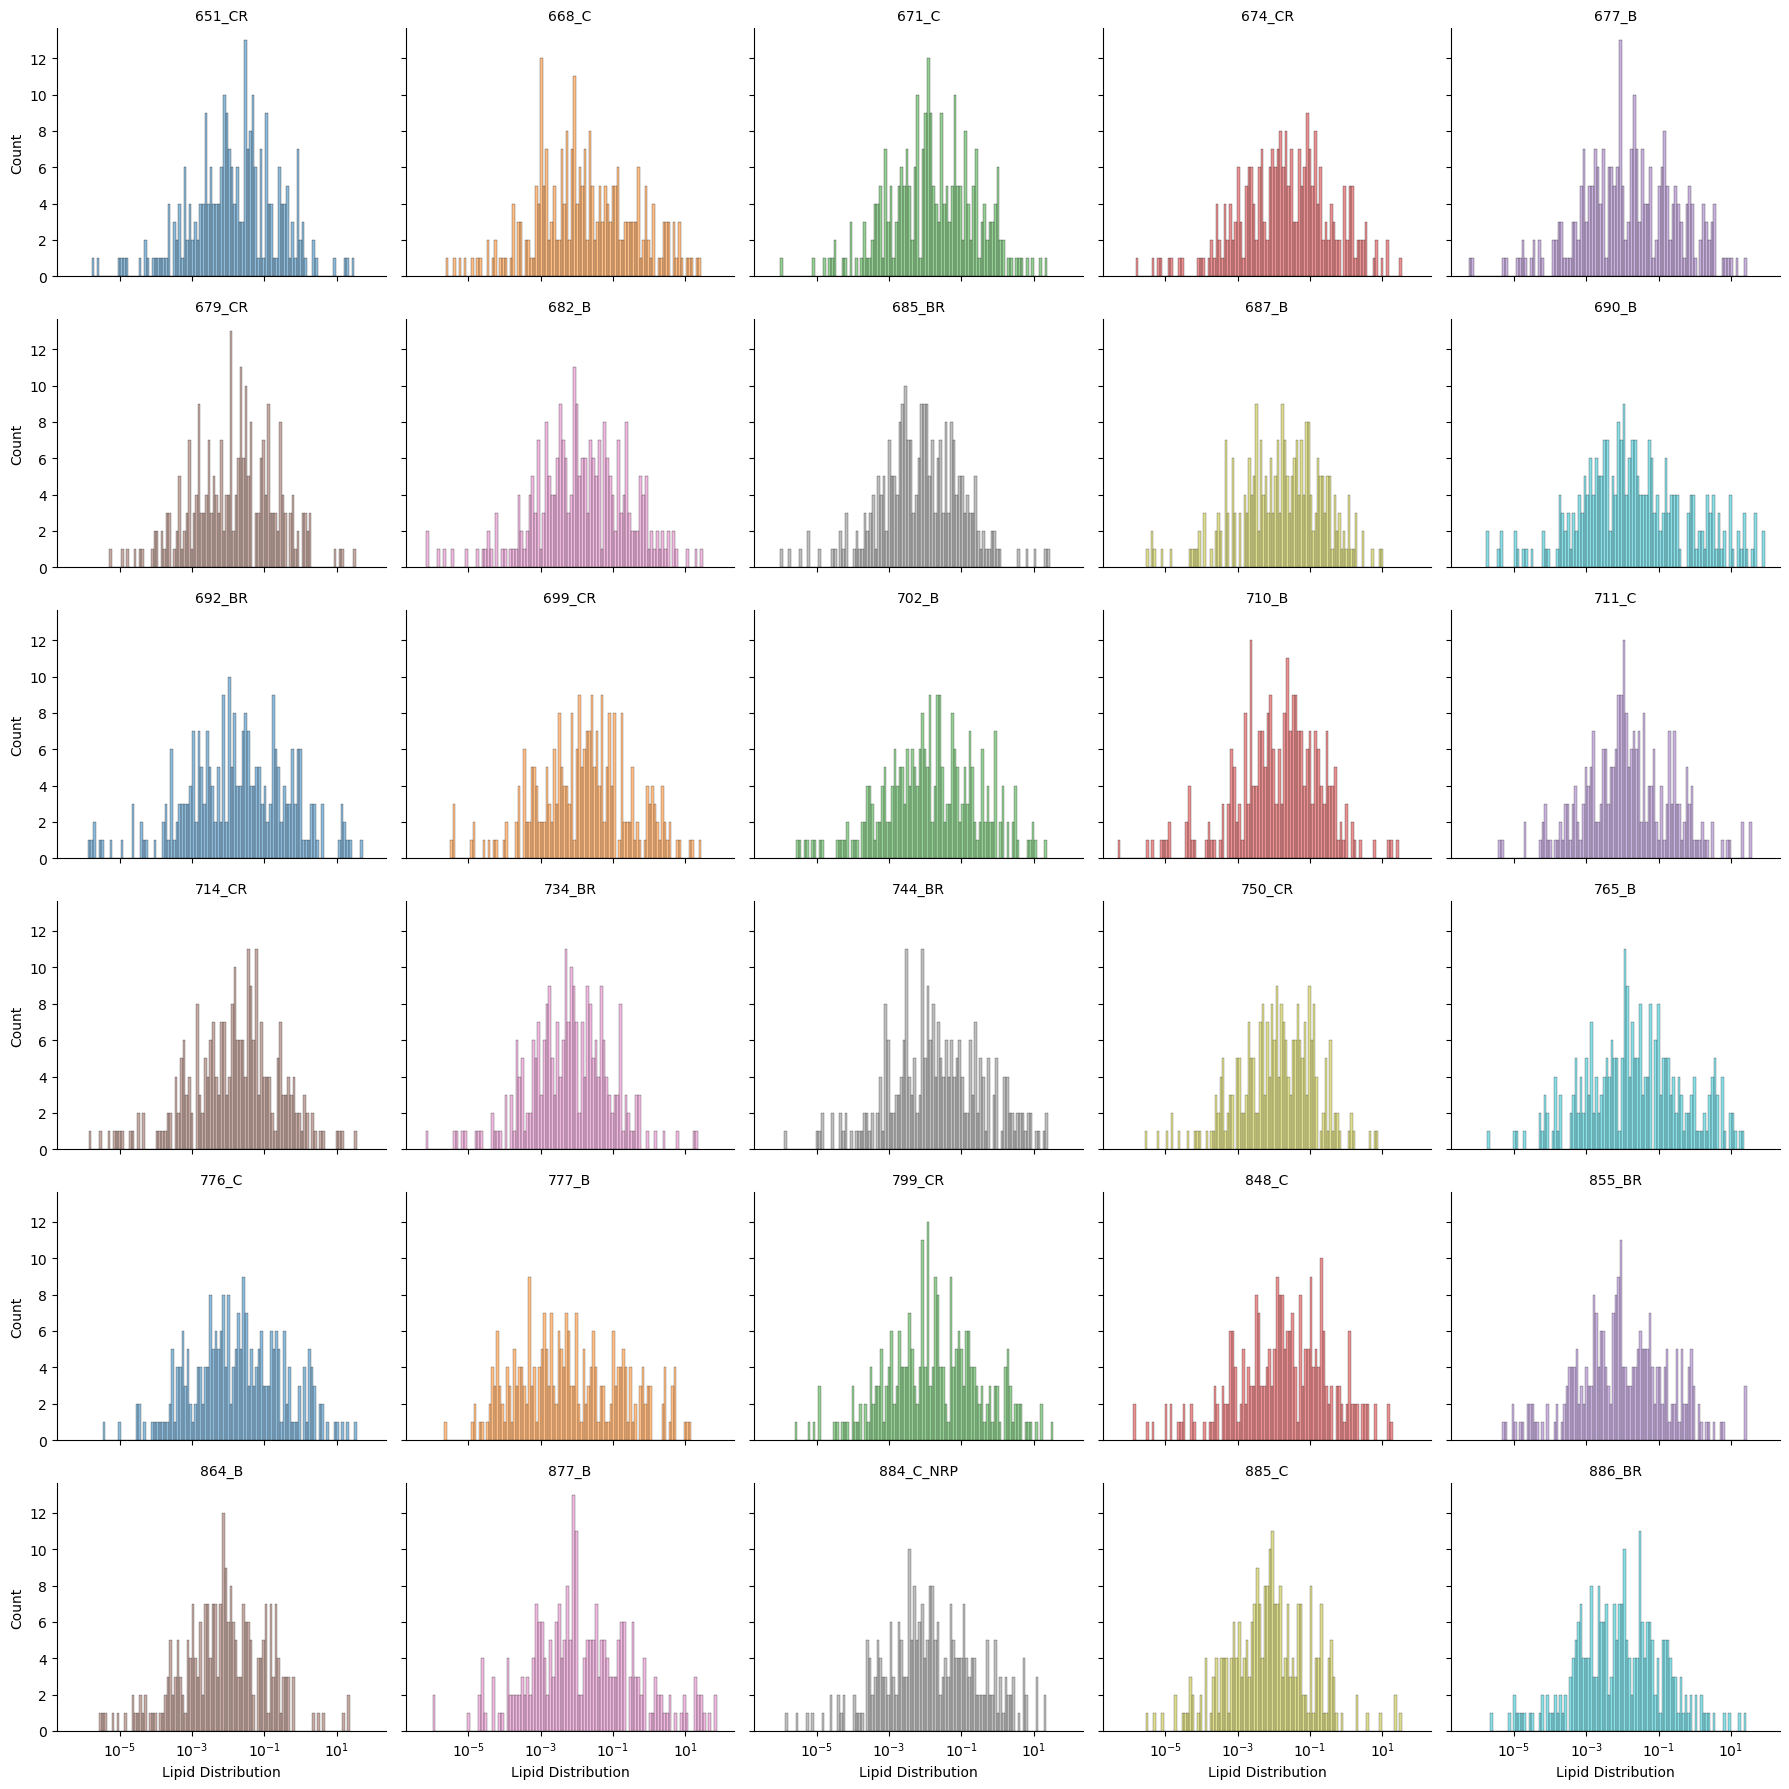

<Figure size 1400x600 with 0 Axes>

In [40]:
# Creating a simple histogram of lipid counts for each donor

# Melt the DataFrame to long format (excluding the 'Group' column)

# Get list of columns excluding 'Group'
dfColsNames = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group'] 

# Starts transforming the DataFrame from wide format to long format using pandas' melt() function.

# Reset index to convert 'Samples' from index to column
lipidomicsLongRawDf = lipidomicsRawAnalysisDf.reset_index().melt(
    id_vars = ['Samples', 'Group'],
    value_vars = dfColsNames,
    var_name = 'Lipid',
    value_name = 'Distribution'
)

# For simplicity rename T1DM_T2DM to T1DM and change the GESTATIONAL DIABETES to HEALTHY
lipidomicsLongRawDf['Group'] = lipidomicsLongRawDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})


# Begin plotting using seaborn's FacetGrid to create histograms for each donor/sample.
facetGridPlot = sns.FacetGrid(
    lipidomicsLongRawDf, 
    col='Samples',
    col_wrap=5, 
    hue='Samples', 
    aspect=1.2, 
    height=3, 
    palette='tab10'
)

facetGridPlot.map(
    sns.histplot, 
    'Distribution', 
    bins=100, 
    kde=True,
    log_scale=True 
)

facetGridPlot.set_titles(col_template="{col_name}")
facetGridPlot.set_xlabels('Lipid Distribution')

plt.figure(figsize=(14, 6))
plt.tight_layout()
plt.show()
plt.close()

In [41]:
# # Conversion of lipid names to RefMet (Reference Metabolome) standard format.

# lipidNamesDF = pd.read_csv('LipidomicsDataforConversion.csv')

# # Put the lipid names into a list for conversion

# lipidNamesOriginalList = lipidNamesDF['Lipid_Names'].tolist()

# # print(lipidNamesOriginalList[:5])

# # Initialise an empty list to store the converted/modified lipid names.

# lipidNamesAlteredList = []

# for lipid in lipidNamesOriginalList:
#      modifiedLipid = lipid.replace('_', ' ', 1)  # The '1' means to replace only the first occurrence with a space
#      modifiedLipid = modifiedLipid.replace('_', ':', 2) # The '2' means to replace the next underscore with a colon
#      if 'Carnitine' in modifiedLipid:
#          modifiedLipid = modifiedLipid.replace('Carnitine', 'CAR')
#      elif 'S ' in modifiedLipid:
#         modifiedLipid = modifiedLipid.replace('S ', 'SHexCer')
#      lipidNamesAlteredList.append(modifiedLipid)

# #print(lipidNamesAlteredList[:20])

# filenameForCorrectLipidList = 'convertedlipidnames.txt'

# # Write the list to a .txt file  

# with open(filenameForCorrectLipidList, 'w') as file:  
#     for lipid in lipidNamesAlteredList:  
#         file.write(lipid + '\n')  # Write each lipid name followed by a newline  

# print(f"Lipid names have been written to {filenameForCorrectLipidList}.") 



This data contains left-censored MNAR data which must be dealt with

Therefore, the modified 80% rule will be used ("variables can be excluded from the data when the proportion of non-missing elements are accounted for less than 80% among each biological group") 

After this, QRILC Imputation will be used in R script called "QRILC_Imputation" using the package imputeLCMD, which has been shown to perform best on left-censored MNAR data 

https://doi.org/10.1038/s41598-017-19120-0


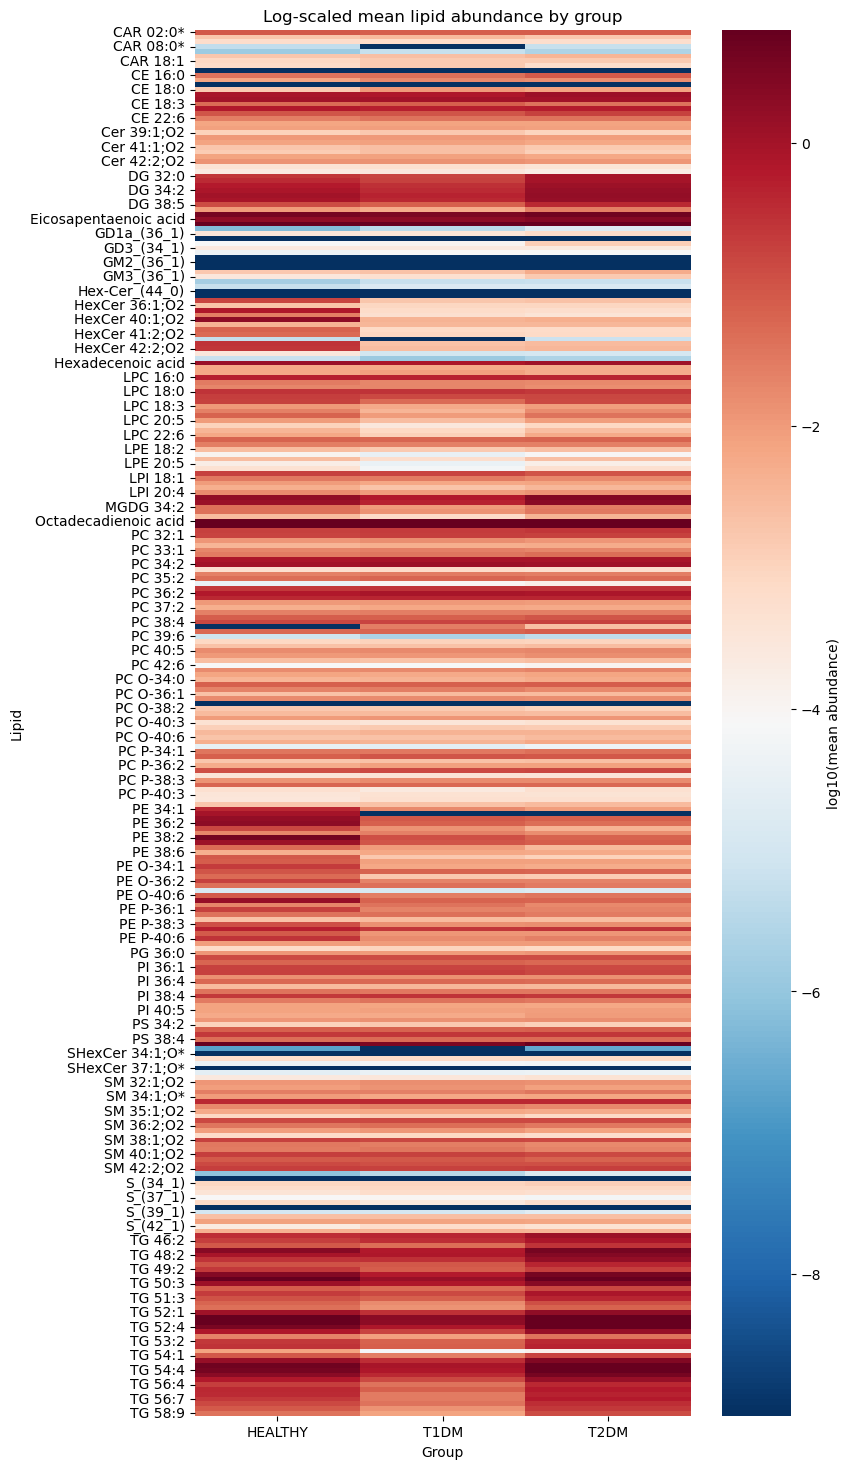

<Figure size 800x1800 with 0 Axes>

In [42]:
# Generate a general heatmap of all lipids across all groups

lipidomicsRawAnalysisDf['Group'] = lipidomicsRawAnalysisDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})

heatmapEverythingDf = lipidomicsLongRawDf.pivot_table(
    index='Lipid',
    columns='Group',
    values='Distribution',
    aggfunc='mean'   # explicit, no magic
)

# Use log10 scale for better visualization
pseudoCount = 1e-9
heatmapEverythingLogDf = np.log10(heatmapEverythingDf + pseudoCount)

# plot heatmap
plt.figure(figsize=(8, 18))

sns.heatmap(
    heatmapEverythingLogDf,
    cmap='RdBu_r',
    robust=True,
    cbar_kws={'label': 'log10(mean abundance)'}
)

plt.xlabel('Group')
plt.ylabel('Lipid')
plt.title('Log-scaled mean lipid abundance by group')
plt.figure(figsize=(8, 18))

plt.tight_layout()
plt.show()
plt.close()

In [43]:
# Run the modified 80% rule to filter lipids based on non-zero values within groups

# Step 1: identify feature columns (exclude 'Group')
featureCols = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group']

# Step 2: create a boolean DataFrame: True if value is non-zero, False if zero
# This is elementwise, creating a DataFrame of booleans (True/False) the same shape as lipidomicsRawAnalysisDf[feature_cols]
nonZeroDf = (lipidomicsRawAnalysisDf[featureCols] != 0)

# Step 3: add the Group column to the boolean DataFrame for grouping
# We need the group information so we can calculate the fraction of non-zero values per group.
nonZeroDf['Group'] = lipidomicsRawAnalysisDf['Group']

# Step 4: compute the fraction of non-zero values per lipid per group
# nonZeroDf.groupby('Group') → splits the DataFrame into sub-DataFrames by unique group.
# .mean() on booleans treats True as 1, False as 0 → calculates fraction of non-zero samples for each lipid in each group.
fractions = nonZeroDf.groupby('Group').mean()

# Step 5: find lipids where the fraction >= 0.8 in any group
keepMask = (fractions >= 0.8).any(axis=0)

# Step 6: apply the mask to keep only the desired lipids + Group column
modified80LipidDf = lipidomicsRawAnalysisDf[['Group'] + keepMask[keepMask].index.tolist()]

print("Original number of lipids:", len(featureCols))
print("Number of lipids after modified 80% rule:", len(modified80LipidDf.columns)-1)


Original number of lipids: 289
Number of lipids after modified 80% rule: 260


In [44]:
# Export the modified DataFrame to a new CSV file for Imputation on R script

modified80LipidDf.index.name = 'Samples'  # Name the index
modified80LipidDf.to_csv('LipidomicsDataModified80PercentRule.csv', index=True)

QRLIC Imputaton completed on R script. Now finishing remaining analysis which includes another heatmap of imputed data and then PCA on the first five components

In [45]:
# Put the imputed csv file output from R into a pandas DataFrame for further analysis

# Load imputed data
imputedLipidDf = pd.read_csv("lipidomics_imputed_data.csv")

# Set Samples as index
imputedLipidDf = imputedLipidDf.set_index("Samples")

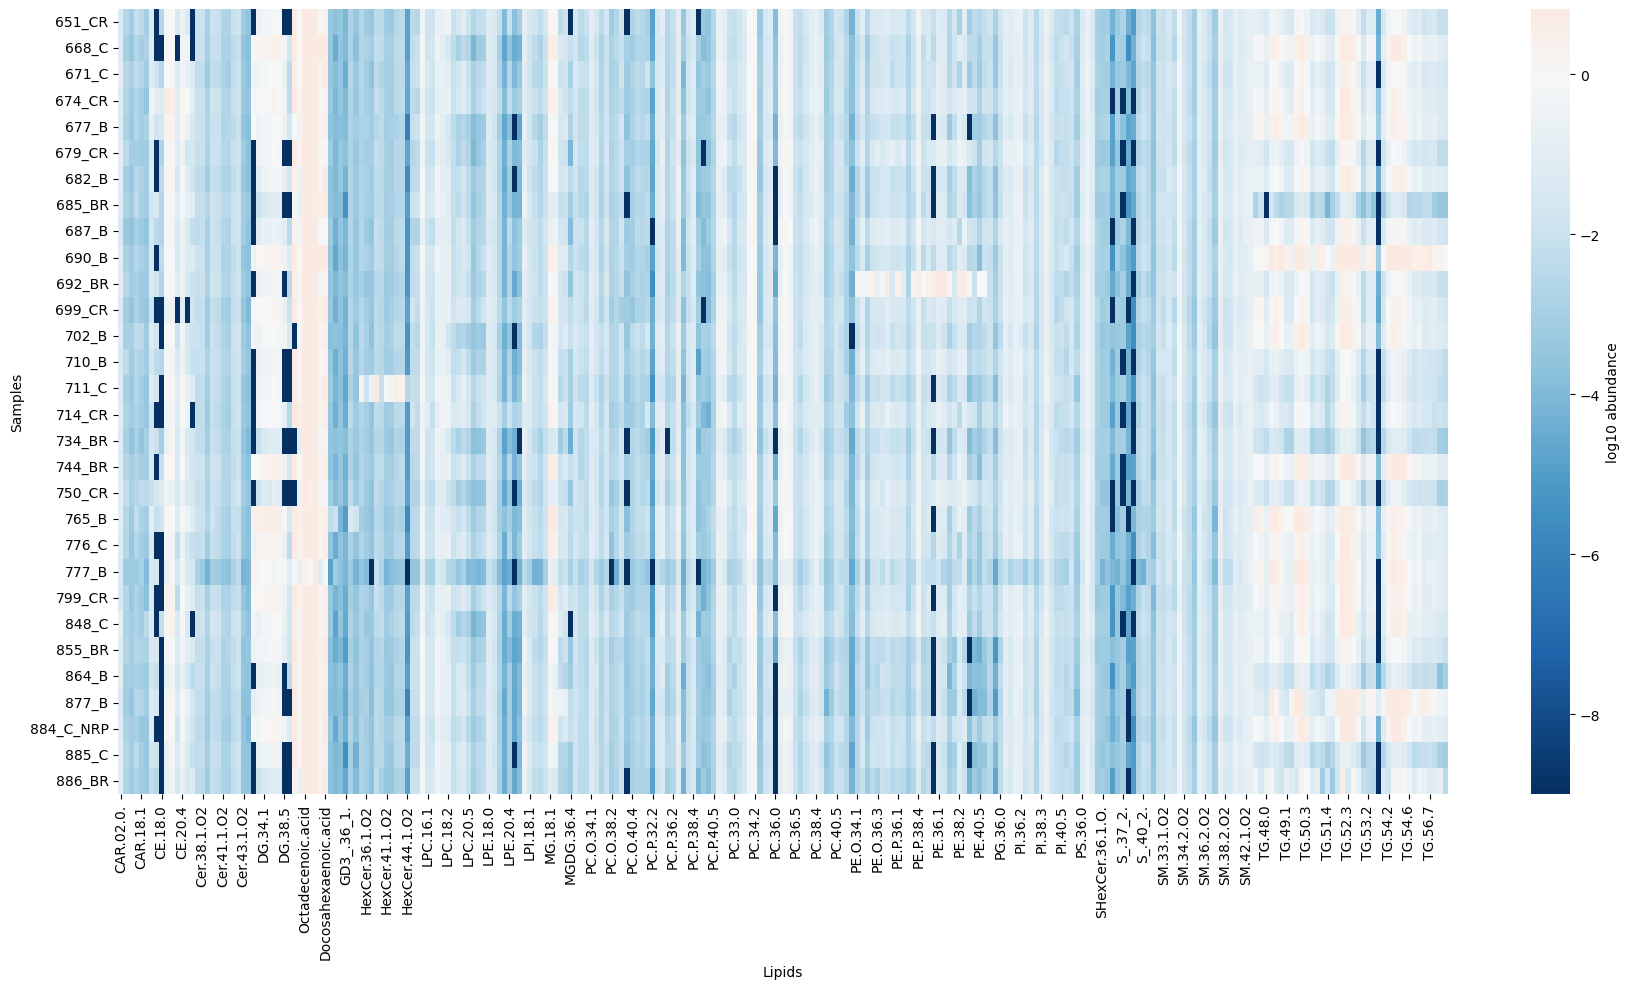

In [46]:
# Heatmap for lipids 

# Separate metadata and lipid matrix
groupLabels = imputedLipidDf["Group"]
lipidMatrix = imputedLipidDf.drop(columns=["Group"])

# Log-transform (recommended for QRILC output)
lipidMatrixLog = np.log10(lipidMatrix + 1e-9)

plt.figure(figsize=(18, 10))
sns.heatmap(
    lipidMatrixLog,
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "log10 abundance"}
)

plt.xlabel("Lipids")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()
plt.close()

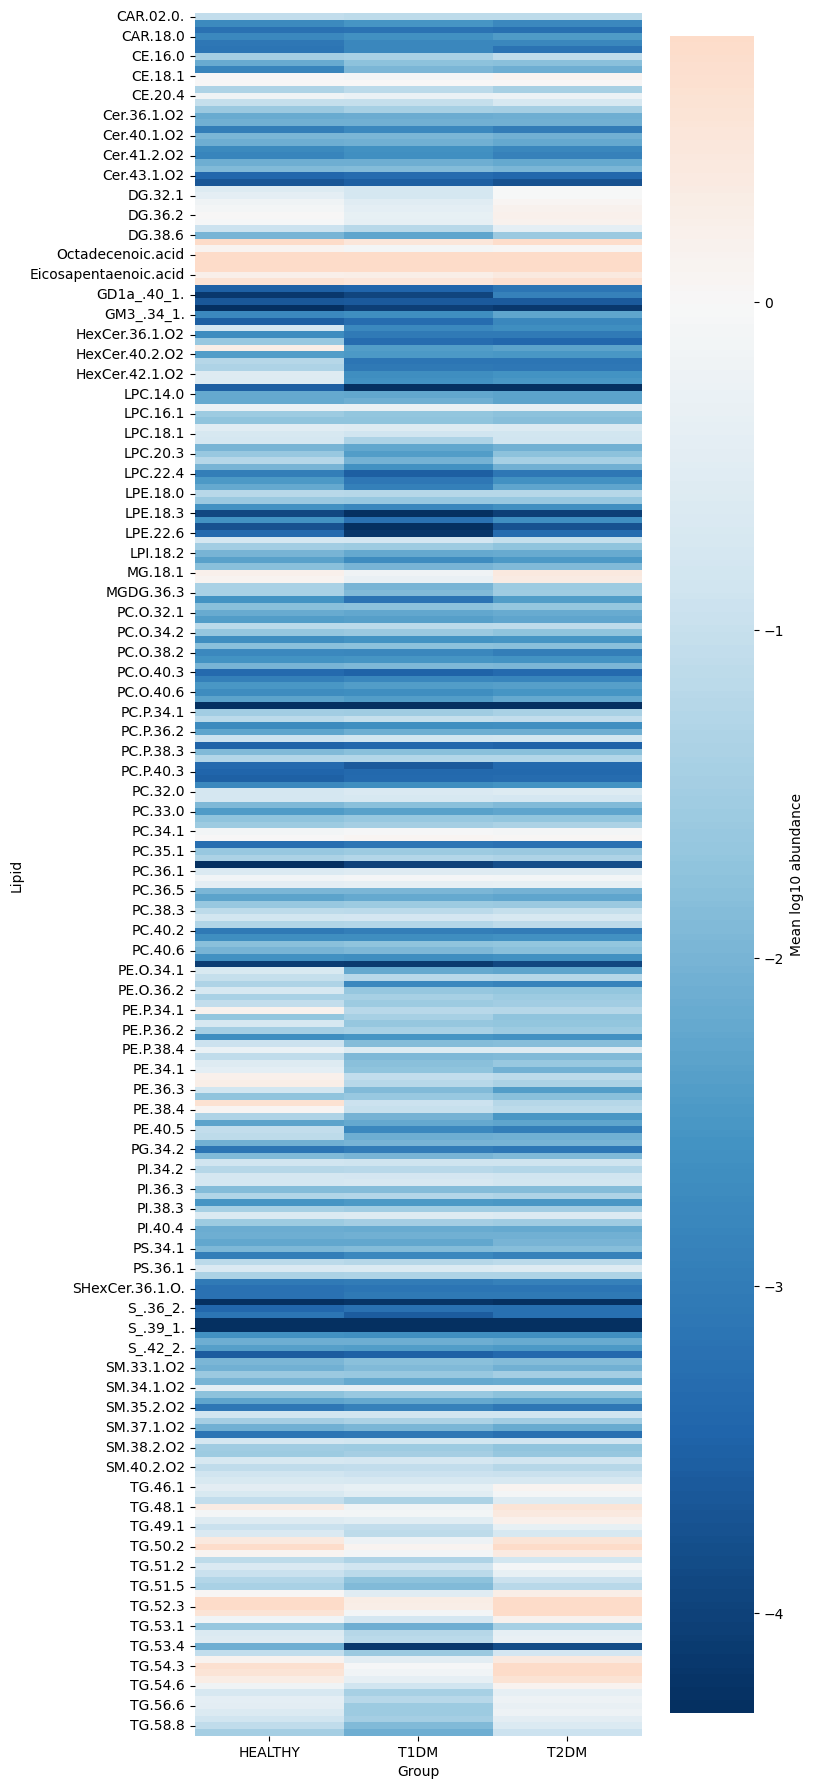

In [47]:
# Combine lipid data with group labels
lipidMatrixWithGroup = lipidMatrix.copy()
lipidMatrixWithGroup["Group"] = groupLabels

# Compute group means
groupMeansDf = lipidMatrixWithGroup.groupby("Group").mean()

# Transpose so lipids are rows
groupMeansTransposedDf = groupMeansDf.T

plt.figure(figsize=(8, 18))
sns.heatmap(
    np.log10(groupMeansTransposedDf + 1e-9),
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Mean log10 abundance"}
)

plt.xlabel("Group")
plt.ylabel("Lipid")
plt.tight_layout()
plt.show()
plt.close()

Log10 Transformation and Pareto Scaling to be run on the data prior to PCA and PLS-DA visualisation 

This data has already been normalised to wet weight of sample.

Scaling lipid intensities by minumum + maximum values is sensitive to outliers and so scaling by root of SD (Pareto) is better.

After this centering is done by either subtracting the mean/median intensity from all values.

Finally log transformation applied as it has scaling-like effect making features more comparable + it helps reveal multiplicative relations between features.

PMID: 34822371. doi: 10.3390/metabo11110713


In [48]:
# Take the original lipid matrix and apply a log10 transform
# 1e-9 is added so we do not take log(0), which is undefined
lipidMatrixLogDf = np.log10(lipidMatrix + 1e-9)


# Define a tool (called ParetoScaler) that will centre and Pareto-scale the data
# This format allows it to work with scikit-learn tools later
class ParetoScaler(BaseEstimator, TransformerMixin):

    # This function looks at the data and calculates summary values
    # X is the data matrix (rows = samples, columns = lipids)
    def fit(self, X, y=None):

        # Calculate the mean value for each lipid (column-wise)
        self.mean_ = X.mean(axis=0)

        # Calculate the standard deviation for each lipid (column-wise)
        # ddof=1 means we are using the sample standard deviation
        # ddof=1 (Delta Degrees of Freedom):Tells the function to use a divisor of 
        # (N-1) (where (N) is the number of samples) instead of the default (N).
        # This calculates the sample standard deviation (unbiased estimator) rather than the population standard deviation ((ddof=0)
        self.std_  = X.std(axis=0, ddof=1)

        # Replace any zero standard deviations with NaN
        # This prevents division by zero during scaling
        self.std_[self.std_ == 0] = np.nan

        # Return the scaler itself (required by scikit-learn)
        return self


    # This function applies Pareto scaling using the values calculated in fit()
    def transform(self, X):

        # Subtract the mean and divide by the square root of the standard deviation
        # This performs mean-centering and Pareto scaling
        return (X - self.mean_) / np.sqrt(self.std_)


# Create an empty ParetoScaler object
# No calculations happen yet
scaler = ParetoScaler()


# Fit the scaler to the log-transformed data
# This calculates and stores the mean and standard deviation for each lipid
scaler.fit(lipidMatrixLogDf)


# Apply Pareto scaling to the log-transformed data
# This returns a NumPy array with scaled values
lipidMatrixPareto = scaler.transform(lipidMatrixLogDf)


# Convert the scaled NumPy array back into a pandas DataFrame
# This restores the original sample names (rows) and lipid names (columns)
lipidMatrixParetoCentreDf = pd.DataFrame(
    lipidMatrixPareto,
    index=lipidMatrixLogDf.index,
    columns=lipidMatrixLogDf.columns
)




In [49]:
# Check the df 
# Line 1: calculates the mean of each lipid (column-wise), 
# takes absolute value (just to ignore negative signs) and finds the largest mean among all lipids
# Line 2: This tells you if any columns became unusable after scaling (i.e., all NaNs)
lipidMatrixPareto.mean(axis=0).abs().max()   # should be ~0
lipidMatrixPareto.isna().sum().sum()         # check dropped lipids

np.int64(0)

In [50]:
# Add Group column directly from original DF using index, no duplicate column
lipidMatrixParetoCentreDf['Group'] = imputedLipidDf.loc[lipidMatrixParetoCentreDf.index, 'Group']

# Move Group to the front (second column after index)
colsLipidCorrectOrder = ['Group'] + [c for c in lipidMatrixParetoCentreDf.columns if c != 'Group']
lipidMatrixParetoCentreDf = lipidMatrixParetoCentreDf[colsLipidCorrectOrder]

# Check result
lipidMatrixParetoCentreDf.head()


,Group,CAR.02.0.,CAR.03.0.,CAR.05.0.,CAR.18.0,CAR.18.1,CAR.18.2,CE.16.0,CE.16.1,CE.18.0,...,TG.54.4,TG.54.5,TG.54.6,TG.56.4,TG.56.5,TG.56.6,TG.56.7,TG.56.8,TG.58.8,TG.58.9
Samples,,,,,,,,,,,,,,,,,,,,,
651_CR,T2DM,-0.404766,0.289116,0.244961,1.129237,1.009846,0.245317,0.069708,-2.269463,1.517670,...,-0.280152,-0.279883,-0.317878,-0.215975,-0.250162,-0.710874,-0.373920,-0.225408,-0.533446,-0.273550
668_C,T2DM,-0.240352,-0.463908,-0.556548,0.149224,-0.175903,0.687820,0.696503,-2.269463,-1.930006,...,0.792486,0.719916,0.671682,0.803638,0.723151,0.529607,0.619835,0.732768,0.667172,0.772671
671_C,T2DM,0.697133,0.512058,0.776934,0.776892,0.753059,0.172958,0.275284,1.544757,1.514844,...,-0.089896,-0.063313,-0.040273,0.080513,0.157521,-0.342904,-0.095936,0.020258,0.123446,0.169197
674_CR,T2DM,-0.071656,0.202335,-0.150441,-0.016681,-0.085615,-0.649448,1.610831,1.974568,2.269564,...,0.300277,0.276761,0.301843,0.382093,0.344837,0.224045,0.181527,0.065163,0.363972,0.421924
677_B,T1DM,-0.186188,-0.244742,-0.223292,0.034551,-0.090804,0.551030,0.987729,1.503010,2.066842,...,0.374384,0.425990,0.501004,0.401466,0.422260,0.323418,0.216219,0.438302,0.338013,0.410921


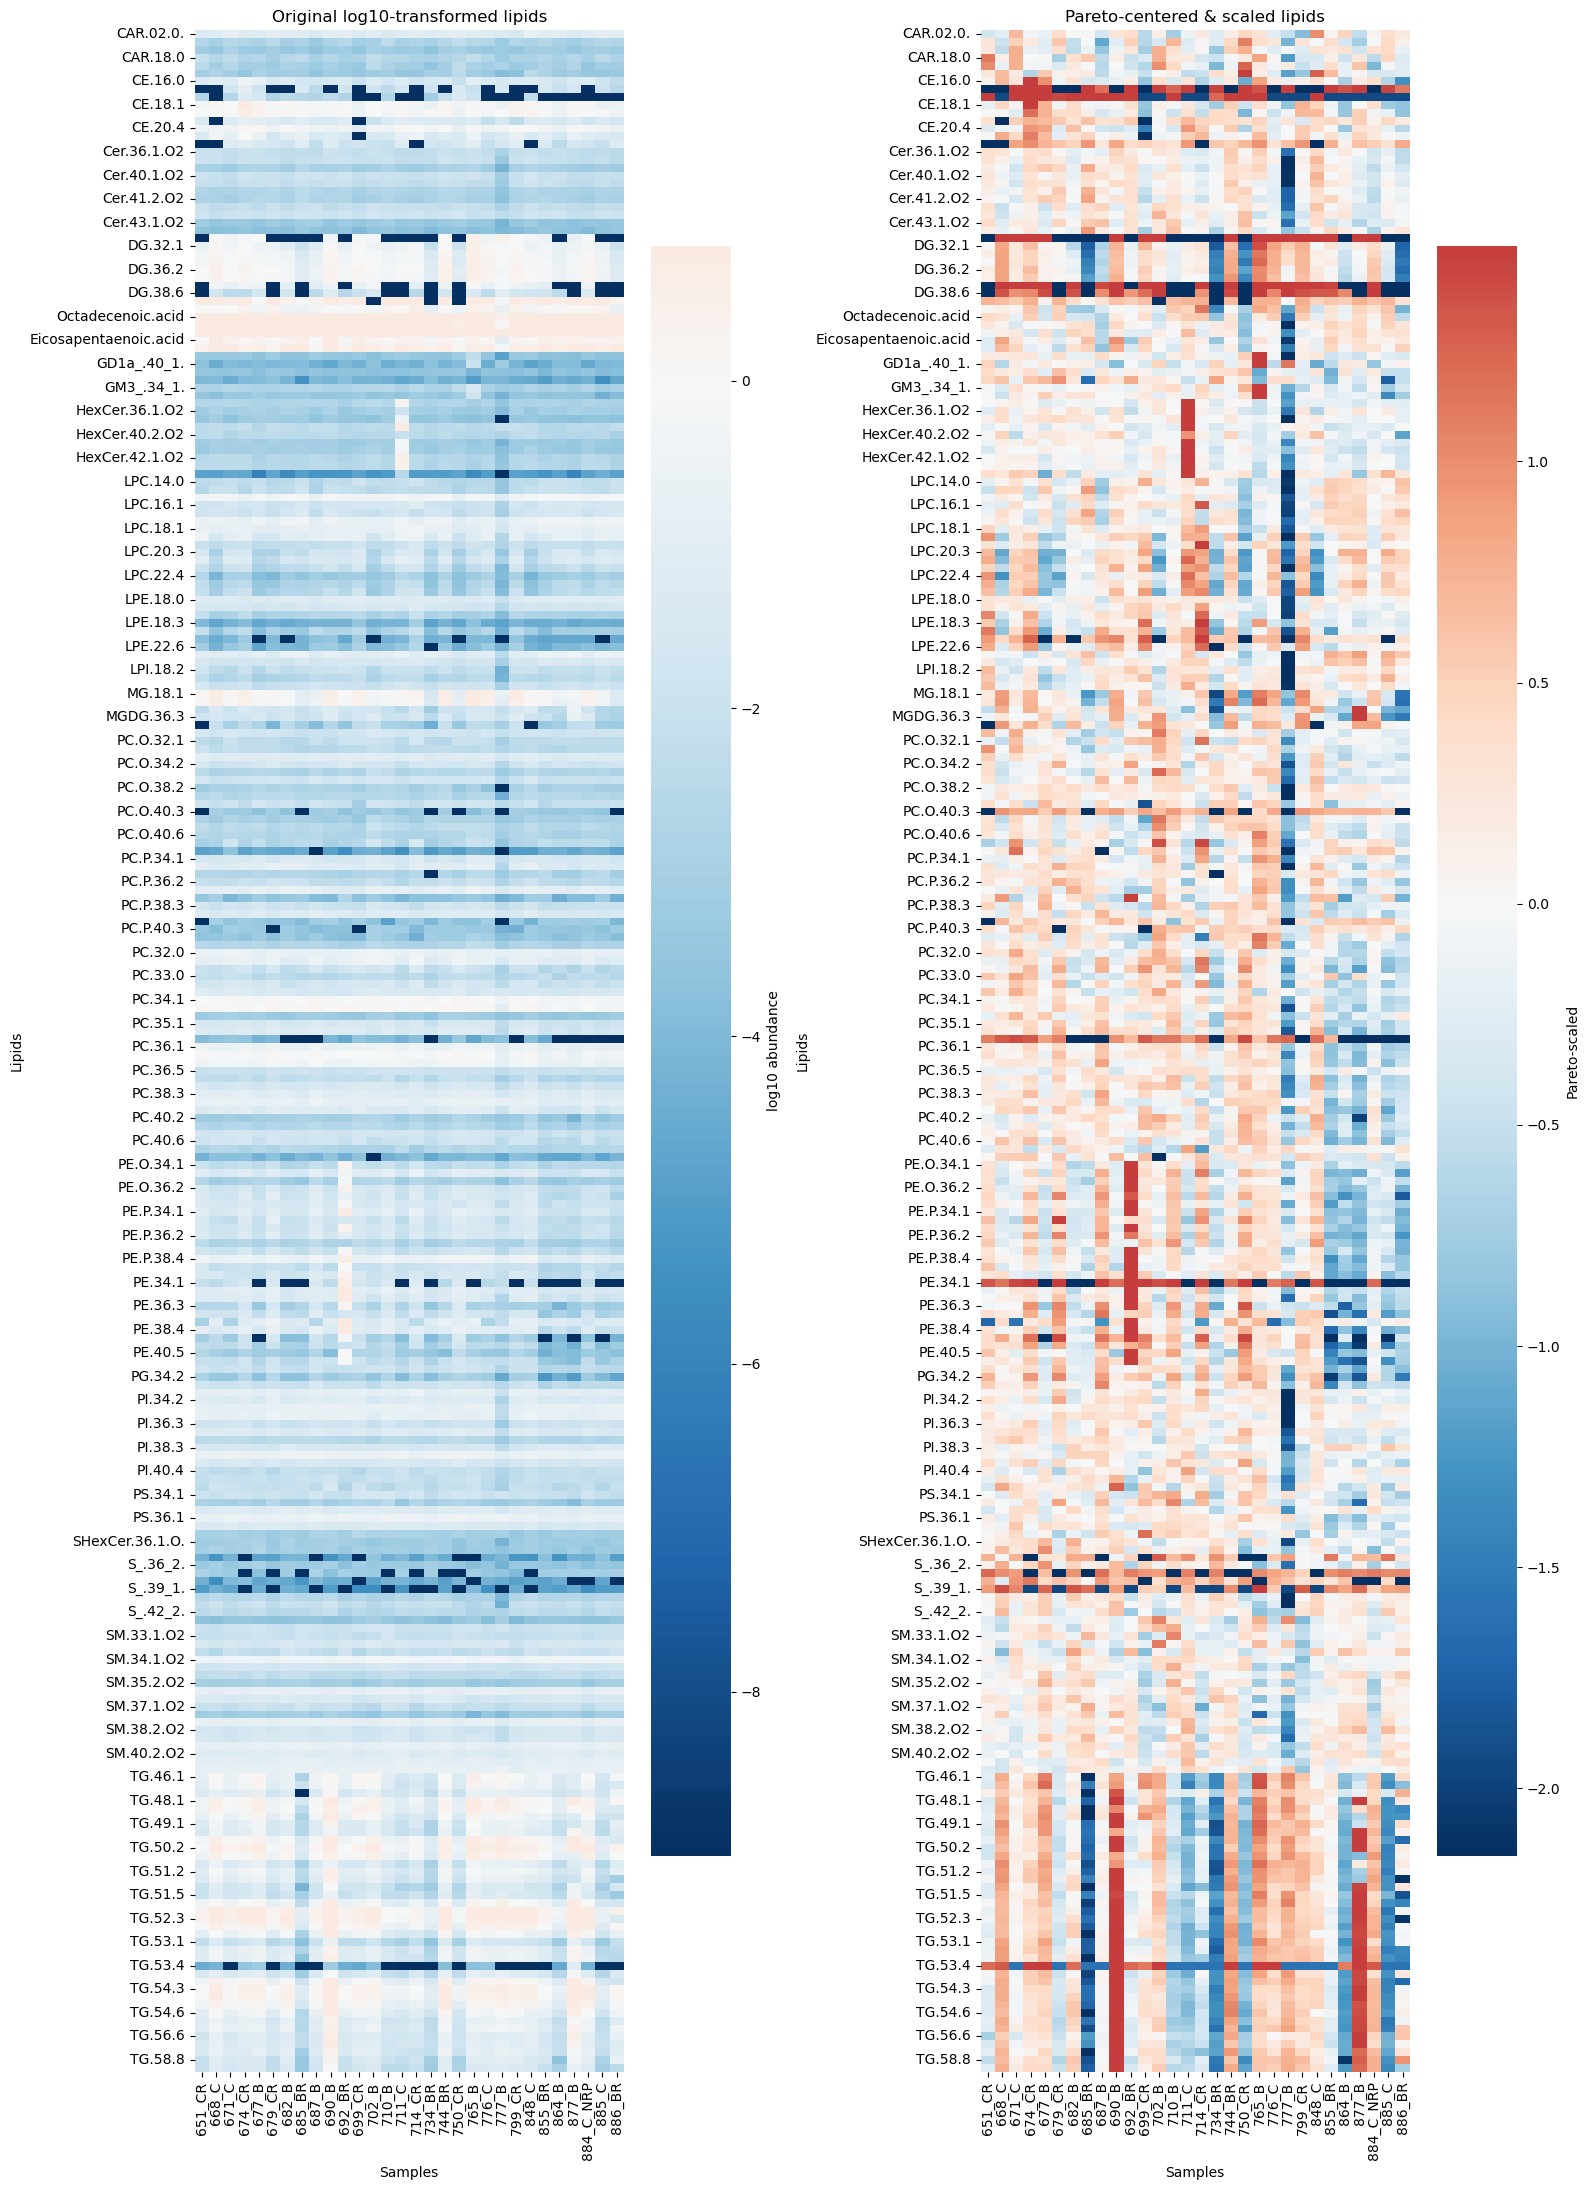

In [51]:
# Heatmap of lipids before and after Pareto scaling (transposed)

# lipidMatrixParetoCentreDf should have lipids columns only (index = samples)
lipidMatrixParetoOnly = lipidMatrixParetoCentreDf.drop(columns=['Group'], errors='ignore')

# Transpose so lipids are rows, samples are columns
lipidMatrixLogT = lipidMatrixLog.T
lipidMatrixParetoT = lipidMatrixParetoOnly.T

# Set figure with 2 heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 22))

# Left: Original log10-transformed data
sns.heatmap(
    lipidMatrixLogT,
    ax=axes[0],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "log10 abundance"}
)
axes[0].set_title("Original log10-transformed lipids")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("Lipids")

# Right: Pareto-centered & scaled data
sns.heatmap(
    lipidMatrixParetoT,
    ax=axes[1],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Pareto-scaled"}
)
axes[1].set_title("Pareto-centered & scaled lipids")
axes[1].set_xlabel("Samples")
axes[1].set_ylabel("Lipids")

plt.tight_layout()
plt.show()
plt.close()


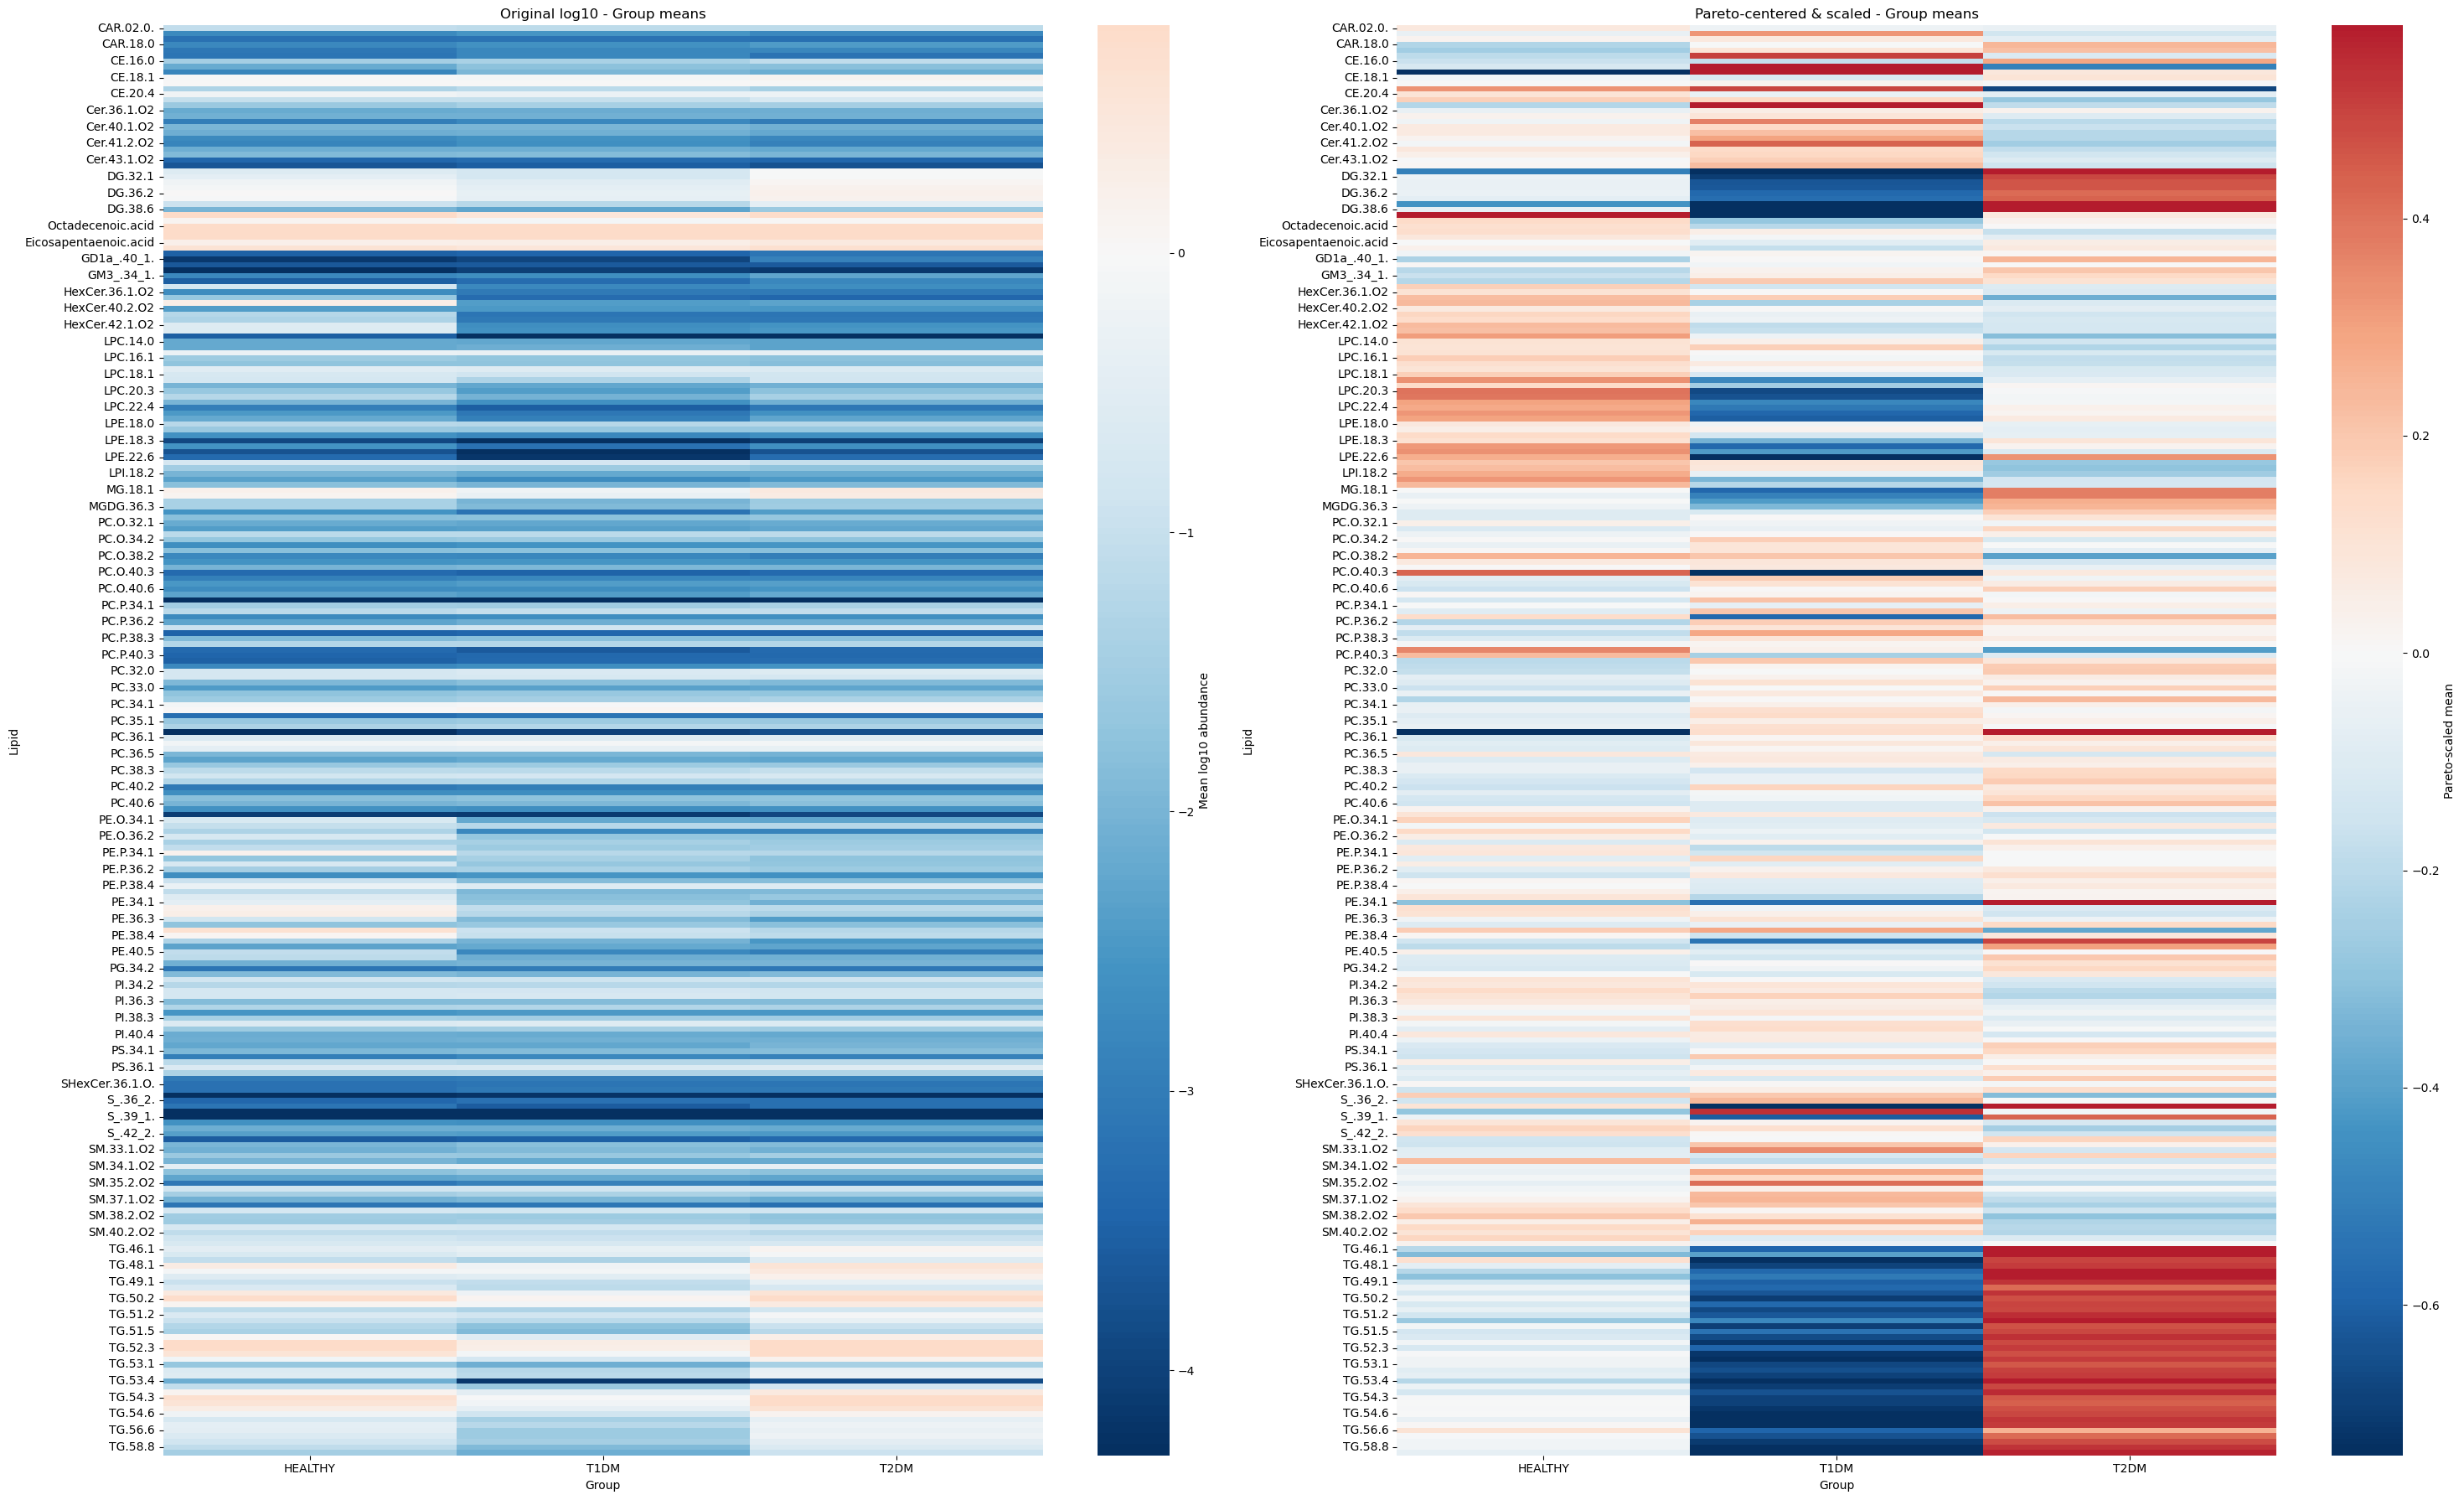

In [52]:
# Combine Pareto-scaled lipid data with group labels
lipidMatrixParetoWithGroup = lipidMatrixParetoCentreDf.copy()
lipidMatrixParetoWithGroup["Group"] = groupLabels  # use the same groupLabels variable

# Compute group means for Pareto-scaled data
groupMeansParetoDf = lipidMatrixParetoWithGroup.groupby("Group").mean()

# Transpose so lipids are rows
groupMeansParetoTransposedDf = groupMeansParetoDf.T

# Set figure with 2 heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(30, 18))  # taller figure for many lipids

# Left: Original log10-transformed group means (already computed)
sns.heatmap(
    np.log10(groupMeansTransposedDf + 1e-9),
    ax=axes[0],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Mean log10 abundance"}
)
axes[0].set_title("Original log10 - Group means")
axes[0].set_xlabel("Group")
axes[0].set_ylabel("Lipid")

# Right: Pareto-scaled group means
sns.heatmap(
    groupMeansParetoTransposedDf,
    ax=axes[1],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Pareto-scaled mean"}
)
axes[1].set_title("Pareto-centered & scaled - Group means")
axes[1].set_xlabel("Group")
axes[1].set_ylabel("Lipid")

plt.tight_layout()
plt.show()
plt.close()

Explained variance ratios for Pareto-scaled data: [0.26169546 0.16888345 0.11915755 0.06179343 0.04214546 0.03896164
 0.03731773 0.03101936 0.02902608 0.0267156 ]
Explained variance ratios for Original log-transformed data: [0.3104049  0.15490802 0.0924288  0.06666867 0.04747968 0.04660788
 0.04077796 0.03670205 0.03361593 0.02410839]


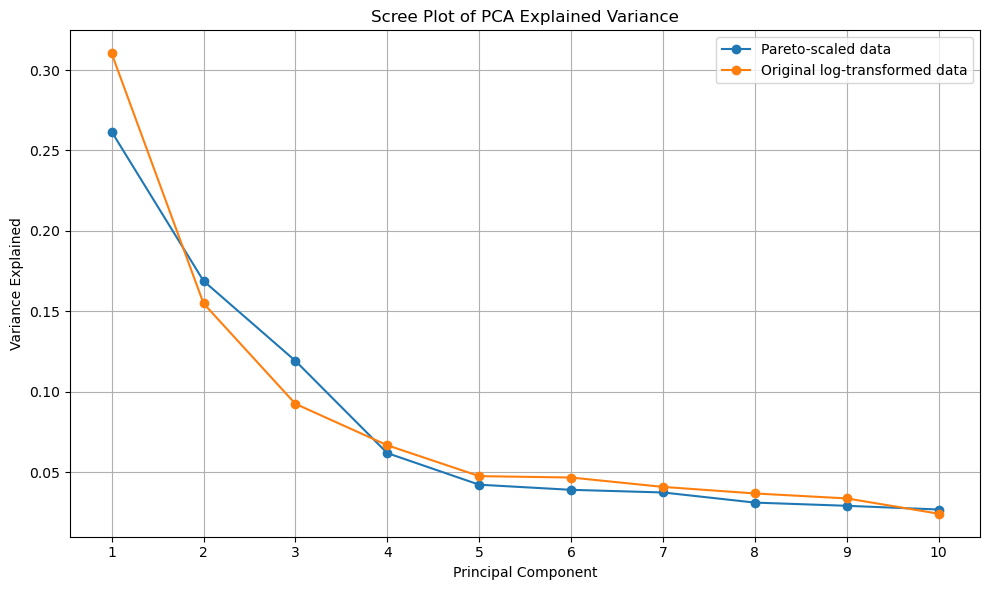

In [53]:
# Generate PCA plots for Pareto-scaled data and original log-transformed data

pca_pareto = PCA(n_components=10)
principalComponentsPareto = pca_pareto.fit_transform(lipidMatrixParetoOnly)

# Put into df
principalComponentsParetoDf = pd.DataFrame(
    data = principalComponentsPareto,
    columns= ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
)

# pca on original log-transformed data

pca_OriginalLog = PCA(n_components=10)
principalComponentsOriginalLog = pca_OriginalLog.fit_transform(lipidMatrixLogDf)

# Put into df
principalComponentsOriginalLogDf = pd.DataFrame(
    data = principalComponentsOriginalLog,
    columns= ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10']
)

# Get the explained variance ratios for both PCAs

print(f'Explained variance ratios for Pareto-scaled data: {pca_pareto.explained_variance_ratio_}')
print(f'Explained variance ratios for Original log-transformed data: {pca_OriginalLog.explained_variance_ratio_}')

# Use scree plot to find 'elbow' point in variance explained

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, 11),
    pca_pareto.explained_variance_ratio_,
    marker='o',
    label='Pareto-scaled data'
)
plt.plot(
    range(1,11),
    pca_OriginalLog.explained_variance_ratio_,
    marker='o',
    label='Original log-transformed data'
)
plt.title('Scree Plot of PCA Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1,11))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

In [54]:
# Add Group labels to PCA DataFrames

# For Pareto-scaled PCA
principalComponentsParetoWithGroupsDf = pd.concat([
    principalComponentsParetoDf.reset_index(drop=True),
    lipidMatrixParetoWithGroup[['Group']].reset_index(drop=False)
], axis=1)

# For Original log-transformed PCA
principalComponentsOriginalLogWithGroupsDf = pd.concat([
    principalComponentsOriginalLogDf.reset_index(drop=True),
    lipidMatrixParetoWithGroup[['Group']].reset_index(drop=False)
], axis=1)

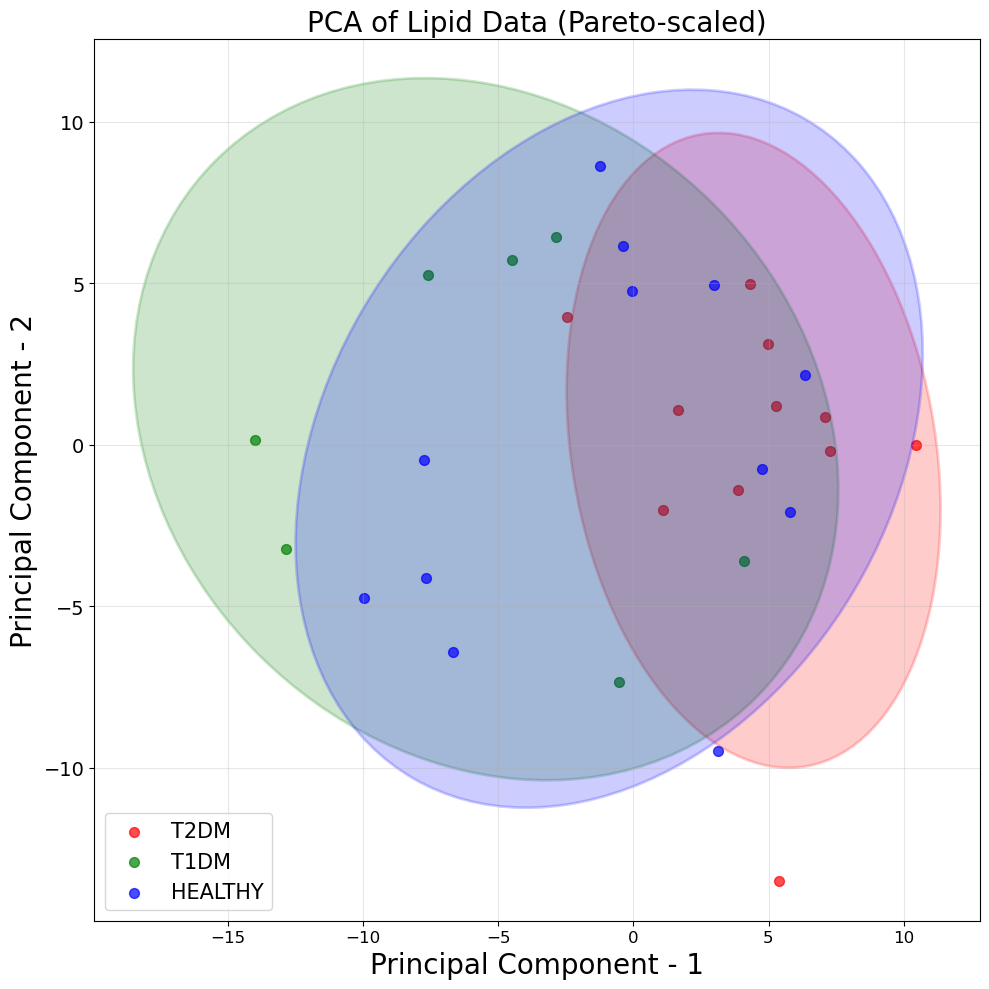

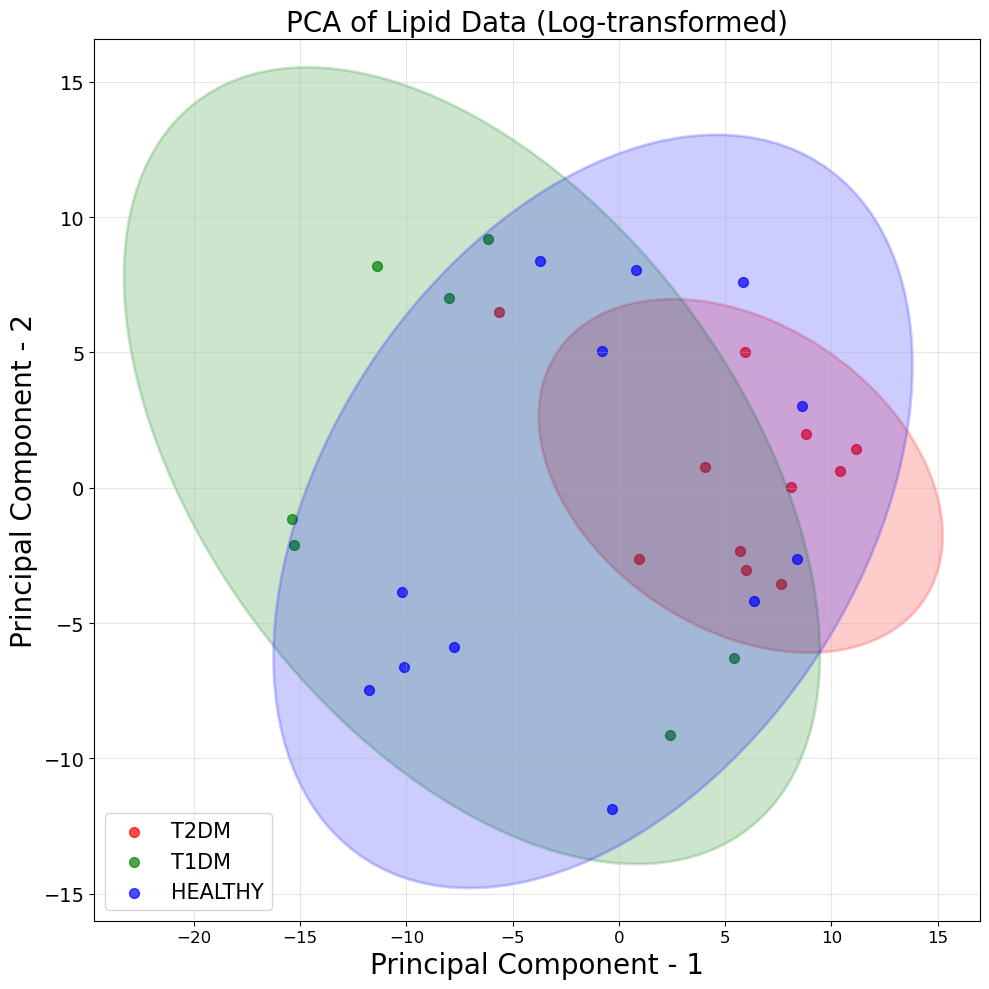

In [55]:
# Function to draw confidence ellipses
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', alpha=0.3, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, **kwargs)
    
    # Calculating the standard deviation of x from the square root of the variance
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# For Pareto-scaled data
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of Lipid Data (Pareto-scaled)",fontsize=20)

# Get unique groups and assign colors
targets = principalComponentsParetoWithGroupsDf['Group'].unique()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple']

for target, color in zip(targets, colors):
    indicesToKeep = principalComponentsParetoWithGroupsDf['Group'] == target
    
    # Scatter plot
    ax.scatter(principalComponentsParetoWithGroupsDf.loc[indicesToKeep, 'PC1'],
               principalComponentsParetoWithGroupsDf.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=0.7, label=target)
    
    # Add confidence ellipse
    x = principalComponentsParetoWithGroupsDf.loc[indicesToKeep, 'PC1'].values
    y = principalComponentsParetoWithGroupsDf.loc[indicesToKeep, 'PC2'].values
    
    if len(x) > 2:  # Need at least 3 points for ellipse
        confidence_ellipse(x, y, ax, n_std=2.0, 
                          facecolor=color, edgecolor=color, 
                          alpha=0.2, linewidth=2)

plt.legend(prop={'size': 15})
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# For Original log-transformed data
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of Lipid Data (Log-transformed)",fontsize=20)

for target, color in zip(targets, colors):
    indicesToKeep = principalComponentsOriginalLogWithGroupsDf['Group'] == target
    
    # Scatter plot
    ax.scatter(principalComponentsOriginalLogWithGroupsDf.loc[indicesToKeep, 'PC1'],
               principalComponentsOriginalLogWithGroupsDf.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=0.7, label=target)
    
    # Add confidence ellipse
    x = principalComponentsOriginalLogWithGroupsDf.loc[indicesToKeep, 'PC1'].values
    y = principalComponentsOriginalLogWithGroupsDf.loc[indicesToKeep, 'PC2'].values
    
    if len(x) > 2:  # Need at least 3 points for ellipse
        confidence_ellipse(x, y, ax, n_std=2.0, 
                          facecolor=color, edgecolor=color, 
                          alpha=0.2, linewidth=2)

plt.legend(prop={'size': 15})
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

Seems there is not much seperation between groups in either df so next step is to look into loadings to find which lipids responsible for these variation

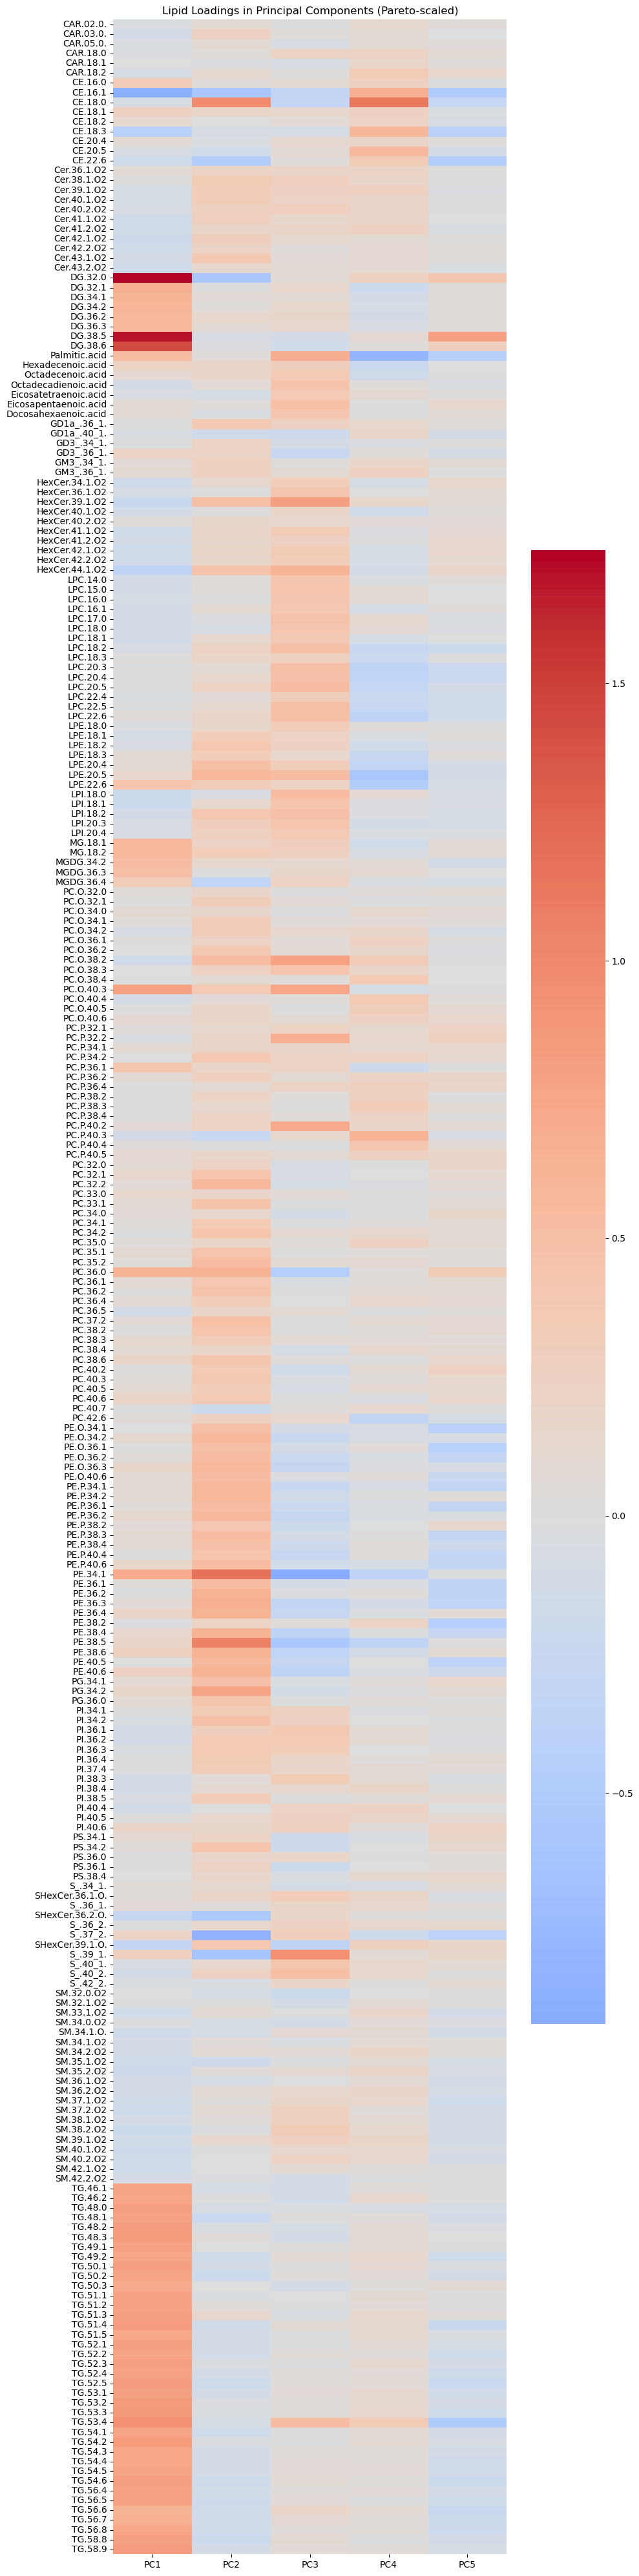

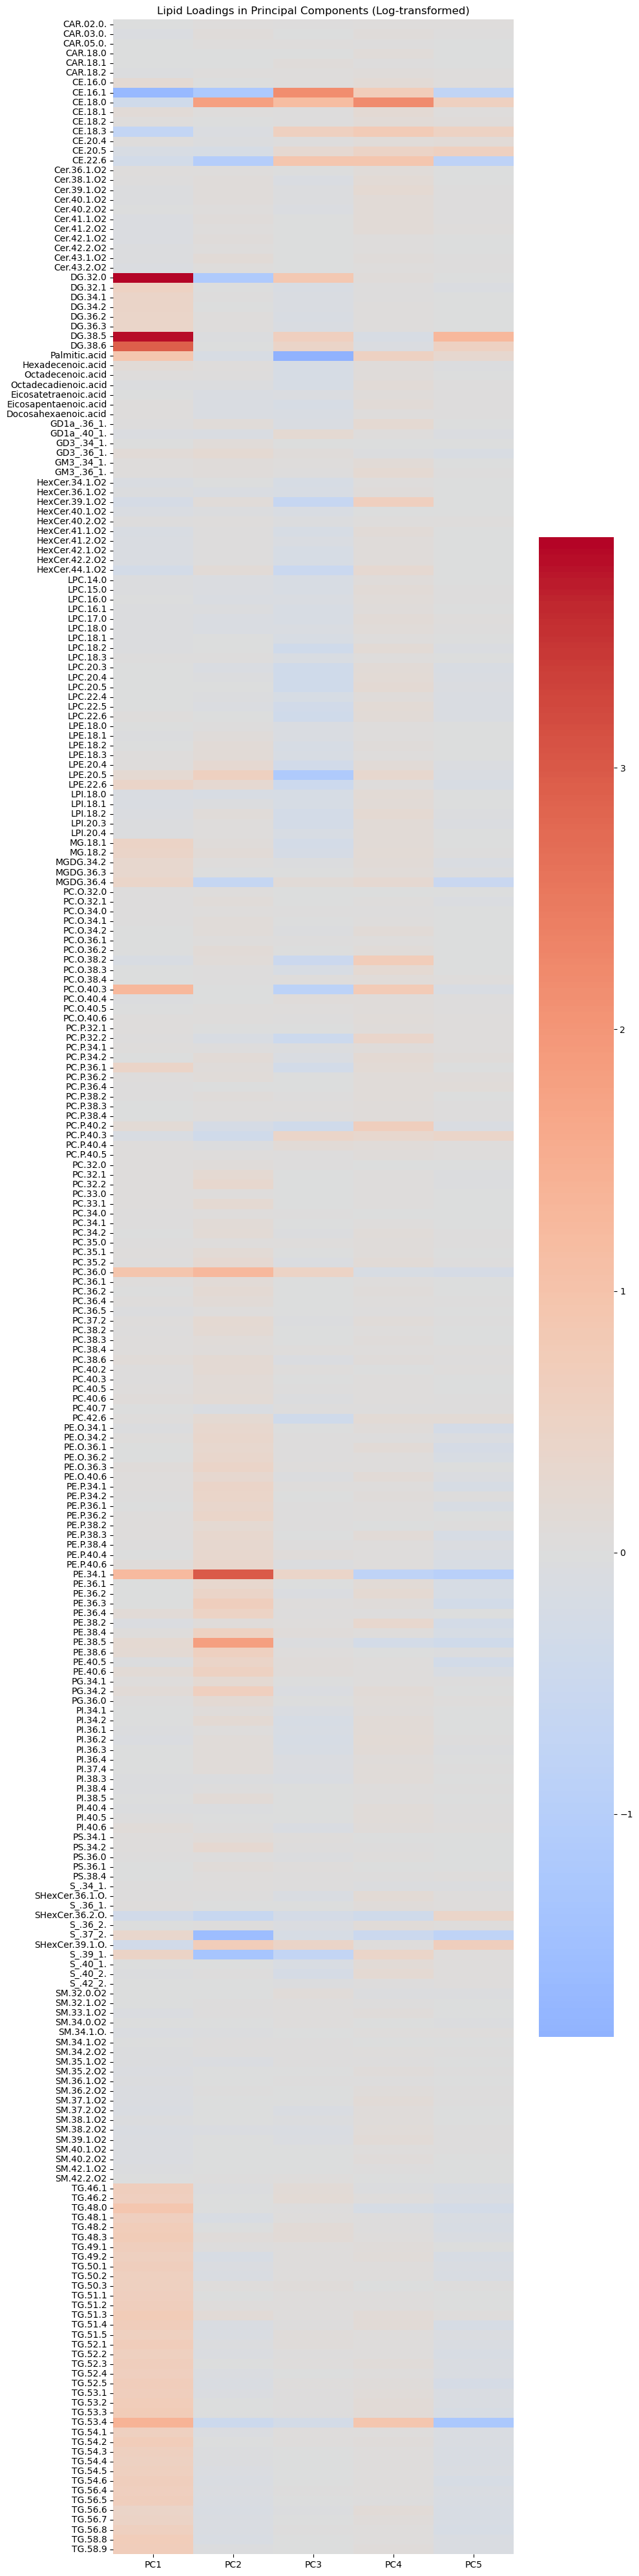

In [56]:
# For Pareto-scaled PCA
loadingsPareto = pca_pareto.components_.T * np.sqrt(pca_pareto.explained_variance_)
# print("Loadings (Pareto-scaled):")
# print(loadingsPareto)

# Get feature names (lipid names)
featureNames = lipidMatrixParetoOnly.columns

# Heatmap for first 5 PCs (or adjust to however many you want)
plt.figure(figsize=(10, 40))
sns.heatmap(loadingsPareto[:, :5], annot=False, cmap='coolwarm', 
            xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], 
            yticklabels=featureNames, center=0)
plt.title('Lipid Loadings in Principal Components (Pareto-scaled)')
plt.tight_layout()
plt.show()

# For Log-transformed PCA
loadingsLog = pca_OriginalLog.components_.T * np.sqrt(pca_OriginalLog.explained_variance_)
# print("\nLoadings (Log-transformed):")
# print(loadingsLog)

plt.figure(figsize=(10, 40))
sns.heatmap(loadingsLog[:, :5], annot=False, cmap='coolwarm', 
            xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], 
            yticklabels=featureNames, center=0)
plt.title('Lipid Loadings in Principal Components (Log-transformed)')
plt.tight_layout()
plt.show()
plt.close()

The next step was to conduct a PCA biplot on both datasets. 
PCA biplot = PCA score plot + loading plot. 
It has:     
Bottom axis: PC1 score.
Left axis: PC2 score.
Top axis: loadings on PC1.
Right axis: loadings on PC2.

This allows you to see both the PC1 and PC2 scores and how strongly the lipid features influence the PC

In [87]:
# Function to create a PCA biplot with scores and loadings

def biplot(score, coeff, labels=None, groups=None, colors=None, title=None):

    # extract PC1 scores for all samples
    xs = score[:, 0]

    # extract PC2 scores for all samples
    ys = score[:, 1]

    # create figure and main axis for the scores (bottom and left axes)
    fig, ax = plt.subplots(figsize=(12, 10))

    # if group labels and colors are provided, plot each group separately
    if groups is not None and colors is not None:

        # find the unique group names
        uniqueGroups = np.unique(groups)

        # loop over groups and their corresponding colors
        for group, color in zip(uniqueGroups, colors):

            # boolean mask selecting samples belonging to the current group
            mask = groups == group

            # scatter plot of the scores for this group
            ax.scatter(xs[mask], ys[mask],
                       c=color, label=group,
                       alpha=0.8, s=70)

        # show legend for the groups
        ax.legend(prop={'size': 12})

    else:
        # plot all samples in one color if no grouping is provided
        ax.scatter(xs, ys, alpha=0.8, s=70)

    # compute the range of the score space along PC1
    scalex = xs.max() - xs.min()

    # compute the range of the score space along PC2
    scaley = ys.max() - ys.min()

    # create a secondary x-axis at the top for the loading scale
    ax_top = ax.twiny()

    # create a secondary y-axis at the right for the loading scale
    ax_right = ax.twinx()

    # set the limits of the top axis so that it corresponds to the
    # original loading values on PC1
    ax_top.set_xlim(ax.get_xlim()[0] / scalex,
                     ax.get_xlim()[1] / scalex)

    # set the limits of the right axis so that it corresponds to the
    # original loading values on PC2
    ax_right.set_ylim(ax.get_ylim()[0] / scaley,
                       ax.get_ylim()[1] / scaley)

    # label the top axis as loading values for PC1
    ax_top.set_xlabel("Loadings PC1")

    # label the right axis as loading values for PC2
    ax_right.set_ylabel("Loadings PC2")

    # choose how many loadings (variables) to display
    topN = 10

    # compute the magnitude of each variable loading in the PC1–PC2 plane
    loadingMagnitudes = np.sqrt(coeff[:, 0]**2 + coeff[:, 1]**2)

    # select the indices of the variables with the largest magnitudes
    topIndices = np.argsort(loadingMagnitudes)[-topN:]

    # draw loading vectors as arrows, scaled into the score space
    for i in topIndices:

        # scale PC1 loading so it fits the score coordinate system
        x_loading = coeff[i, 0] * scalex

        # scale PC2 loading so it fits the score coordinate system
        y_loading = coeff[i, 1] * scaley

        # draw an arrow from the origin to the scaled loading coordinates
        ax.arrow(0, 0,
                 x_loading, y_loading,
                 color='darkred',
                 alpha=0.6,
                 head_width=0.2,
                 head_length=0.2,
                 length_includes_head=True)

        # add a text label for the variable at the arrow tip
        if labels is not None:
            ax.text(x_loading * 1.05,
                    y_loading * 1.05,
                    labels[i],
                    color='darkred',
                    fontsize=9,
                    ha='center',
                    va='center')

    # label the bottom axis as the score values for PC1
    ax.set_xlabel("PC1 (scores)")

    # label the left axis as the score values for PC2
    ax.set_ylabel("PC2 (scores)")

    # set the plot title only if provided
    if title is not None:
        ax.set_title(title)

    # show a light grid on the score axes
    ax.grid(alpha=0.3)

    # adjust layout so labels and axes do not overlap
    plt.tight_layout()

    # display the figure
    plt.show()
    plt.close()


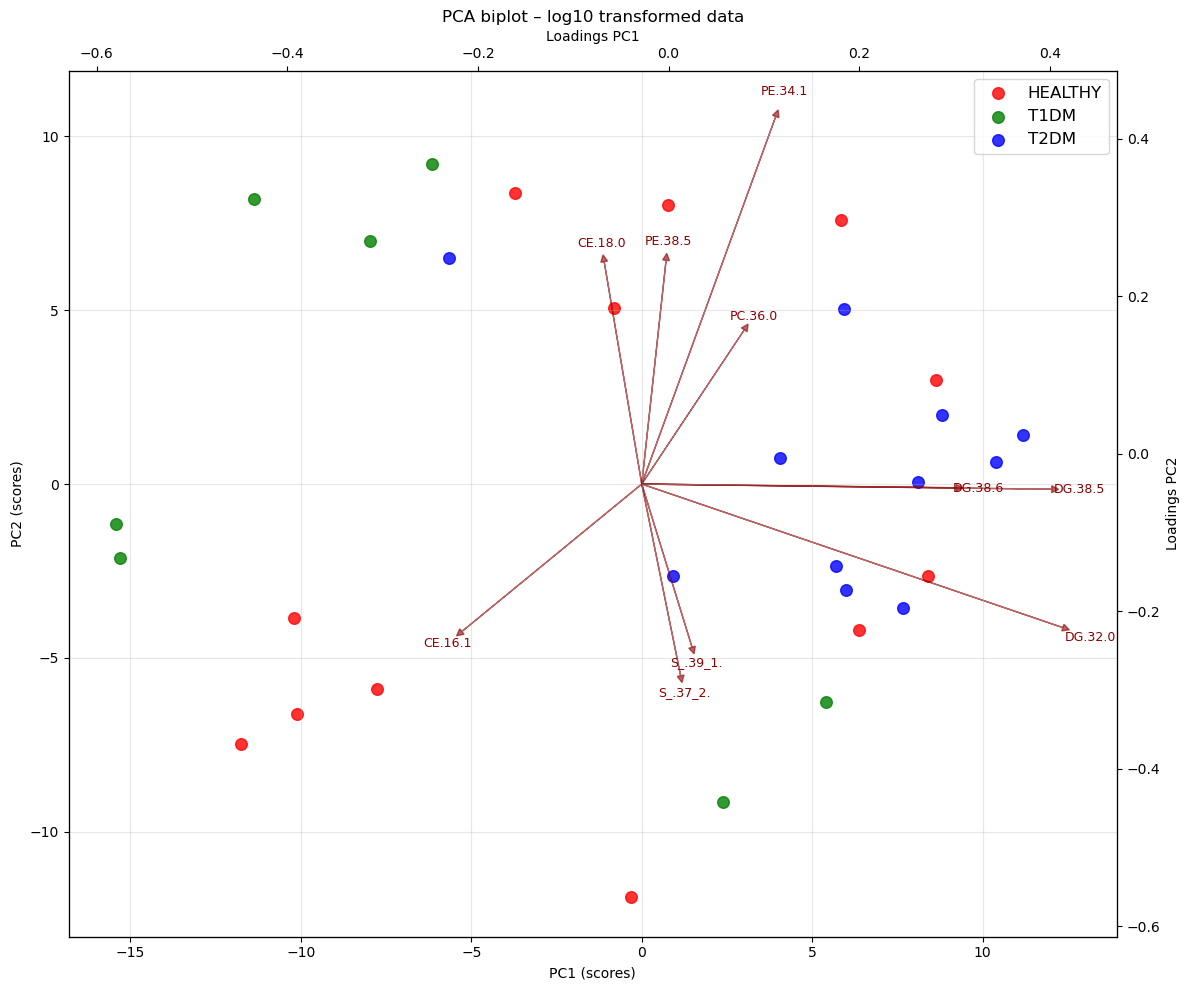

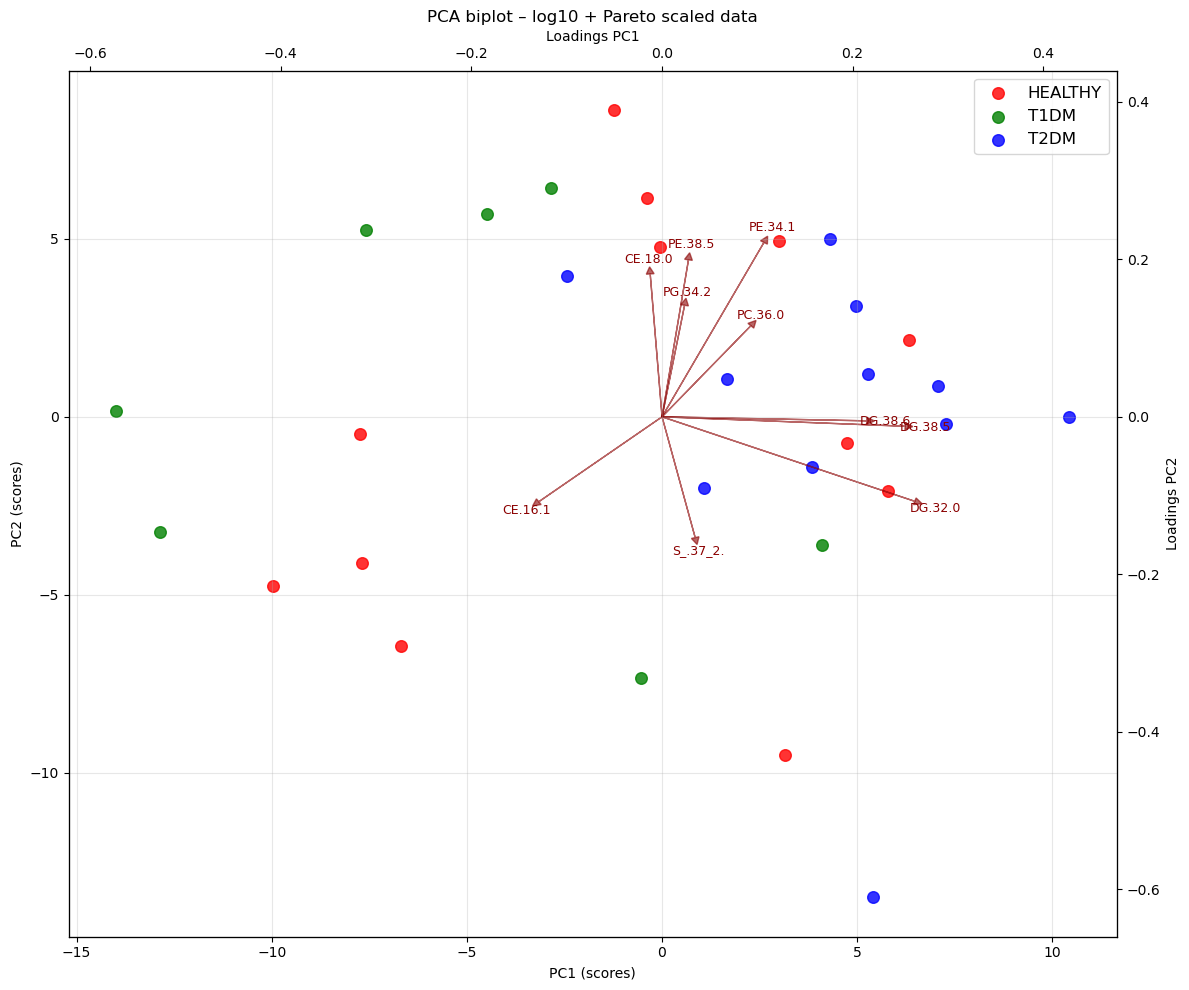

In [58]:
# Call on the function

biplot(
    principalComponentsOriginalLogDf.values,
    pca_OriginalLog.components_.T,
    labels=featureNames,
    groups=principalComponentsOriginalLogWithGroupsDf['Group'].values,
    colors=['r','g','b'],
    title="PCA biplot – log10 transformed data"
)

biplot(
    principalComponentsParetoDf.values,
    pca_pareto.components_.T,
    labels=featureNames,
    groups=principalComponentsParetoWithGroupsDf['Group'].values,
    colors=['r','g','b'],
    title="PCA biplot – log10 + Pareto scaled data"
)


Next step is to run a PLS-DA plot on the data
Partial Least-Squares Discriminant Analysis (PLS-DA) is a multivariate dimensionality-reduction tool

It is in essence a  “supervised” version of PCA whereby it achieves dimensionality reduction but with full awareness of the class labels
Alongside it's use in dimensionality-reduction, it can also be adapted to be used for feature selection and for classification 

Due to overfitting, cross-validation (CV) is an important step in using PLS-DA as a feature selector, classifier or even just for visualization 

For PCA, the first PC tries to preserve as much variance in the original data as possible whereas PLS-DA tries to preserves in its first PC as much covariance as possible between the original data and its labeling 

When running PLS-DA, the maximum number of discriminative latent components is K − 1,
where K = number of classes, so 2 components will be fitted for 3 groups

PMID: 33297937

In [ ]:
lipidMatrixLogDfWithGroup = lipidMatrixLogDf.copy()
lipidMatrixLogDfWithGroup = lipidMatrixLogDfWithGroup.join(groupLabels.rename("Group"))
# print(lipidMatrixLogDfWithGroup.head())
# assert lipidMatrixLogDfWithGroup.index.equals(groupLabels.index)


(30, 261)

In [79]:
# Ensure both DataFrames contain the same samples in the same order
# This prevents silent misalignment between X and y
assert lipidMatrixParetoWithGroup.index.equals(lipidMatrixLogDfWithGroup.index)

# Extract the group labels once (single source of truth for class membership)
# These labels are shared by both Pareto- and log-transformed datasets
y = lipidMatrixParetoWithGroup["Group"]

# Create the Pareto-scaled feature matrix by removing the Group column
# Resulting array has shape (n_samples, n_features)
X_pareto = lipidMatrixParetoWithGroup.drop(columns="Group").values

# Create the log-transformed feature matrix by removing the Group column
# Uses the same samples and features as X_pareto
X_log = lipidMatrixLogDfWithGroup.drop(columns="Group").values

# Initialise the LabelBinarizer to convert class labels into a one-hot encoded matrix
lb = LabelBinarizer()

# Fit the binarizer on the group labels and transform them into a dummy matrix
# For 3 groups (HEALTHY, T1DM, T2DM), this produces shape (n_samples, 3)
Y_bin = lb.fit_transform(y)

# Print the shape of the response matrix to confirm correct multiclass encoding
print("Y_bin shape:", Y_bin.shape)

# Print the class order used in the one-hot encoding (important for interpretation)
print("Classes order:", lb.classes_)


Y_bin shape: (30, 3)
Classes order: ['HEALTHY' 'T1DM' 'T2DM']


In [81]:
# Define the number of latent components (K - 1 = 2 for 3 classes)
# 
nComponents = 2

# Initialise the PLS-DA model for Pareto-scaled data
plsDaPareto = PLSRegression(n_components=nComponents)

# Fit the PLS-DA model using the Pareto-scaled feature matrix and one-hot encoded labels
plsDaPareto.fit(X_pareto, Y_bin)

# Initialise the PLS-DA model for log-transformed data (already preprocessed)
plsDaLog = PLSRegression(n_components=nComponents)

# Fit the PLS-DA model using the log-transformed feature matrix and the same labels
plsDaLog.fit(X_log, Y_bin)

,"n_components n_components: int, default=2Number of components to keep. Should be in `[1, n_features]`.",2
,"scale scale: bool, default=TrueWhether to scale `X` and `y`.",True
,"max_iter max_iter: int, default=500The maximum number of iterations of the power method when`algorithm='nipals'`. Ignored otherwise.",500
,"tol tol: float, default=1e-06The tolerance used as convergence criteria in the power method: thealgorithm stops whenever the squared norm of `u_i - u_{i-1}` is lessthan `tol`, where `u` corresponds to the left singular vector.",1e-06
,"copy copy: bool, default=TrueWhether to copy `X` and `y` in :term:`fit` before applying centering,and potentially scaling. If `False`, these operations will be doneinplace, modifying both arrays.",True


In [ ]:
# Extract latent variable scores for Pareto-scaled data
scoresPareto = plsDaPareto.x_scores_

# Extract latent variable scores for log-transformed data
scoresLog = plsDaLog.x_scores_

# Create a DataFrame for Pareto PLS-DA scores with sample identifiers
scoresParetoDf = pd.DataFrame(
    scoresPareto,                                    # Latent variable scores
    index=lipidMatrixParetoWithGroup.index,          # Sample IDs
    columns=["LV1", "LV2"]                            # Latent variable names
)

# Add group labels for colouring and stratification
scoresParetoDf["Group"] = y

# Create a DataFrame for log-transformed PLS-DA scores
scoresLogDf = pd.DataFrame(
    scoresLog,                                       # Latent variable scores
    index=lipidMatrixLogDfWithGroup.index,            # Sample IDs
    columns=["LV1", "LV2"]                            # Latent variable names
)

# Add group labels to the log score DataFrame
scoresLogDf["Group"] = y

In [90]:
# Pareto scaled PLS-DA scores plot

# Convert one-hot encoded labels to class indices
# StratifiedKFold doesn't work with one-hot encoded matrices, 
# it needs a single class label per sample. 
# Therefore we take the argmax across the columns of Y_bin to get the class index for each sample.
# In essence the argmax is looking for what location the 1 in the one-hot encoding is in. 
# So if [1, 0, 0] → class index 0 (HEALTHY), if [0, 1, 0] → class index 1 (T1DM), if [0, 0, 1] → class index 2 (T2DM).
classIndices = np.argmax(Y_bin, axis=1)

# Define a stratified K-fold cross-validation scheme
# In biomedical data, classes are often imbalanced: some groups may have more samples than others.
# StratifiedKFold ensures that each fold has approximately the same class distribution as the original dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 fold cross-validation, shuffling data before splitting, and setting a random seed for reproducibility

# Create a list to store cross-validated accuracies for Pareto data
cvAccuracyPareto = []

# Initialize an array to store cross-validated continuous predictions for all samples
yPredCVPareto = np.zeros_like(Y_bin, dtype=float)

# Whats being tested here is how well the PLS-DA model can classify samples into their correct groups based on the latent variable scores.
# e.g. each iteration tests "If I did NOT see these samples during training,
# would I still classify them correctly?"

# Perform cross-validation
for trainIndex, testIndex in cv.split(X_pareto, classIndices):
    XTrain, XTest = X_pareto[trainIndex], X_pareto[testIndex]   # Split feature matrix
    yTrain, yTest = Y_bin[trainIndex], Y_bin[testIndex]         # Split label matrix

    plsDaPareto.fit(XTrain, yTrain)                              # Fit PLS-DA on training data
    yPred = plsDaPareto.predict(XTest)                           # Predict continuous responses
    
    # Store continuous predictions for the test samples
    yPredCVPareto[testIndex] = yPred

    yPredClass = np.argmax(yPred, axis=1)                        # Assign class via maximum response

    cvAccuracyPareto.append(
        accuracy_score(classIndices[testIndex], yPredClass)     # Compute classification accuracy
    )

# Print mean cross-validated accuracy for Pareto-scaled data
print("Mean CV accuracy (Pareto):", np.mean(cvAccuracyPareto))

# Convert continuous predictions to class labels for all samples
yPredClassCVPareto = np.argmax(yPredCVPareto, axis=1)

# Confusion matrix for all samples
from sklearn.metrics import confusion_matrix
confusionPareto = confusion_matrix(classIndices, yPredClassCVPareto)
print("Confusion matrix (Pareto):\n", confusionPareto)

# It seems When the model is tested on unseen samples, it correctly assigns the group
# ~57% of the time, averaged over all CV folds. 
# This suggest weak–moderate discrimination between groups possibly due to small sample size, complex disease (high dimensionality), or overlapping phenotypes (T1DM vs T2DM) in the latent variable space.


Mean CV accuracy (Pareto): 0.5666666666666667
Confusion matrix (Pareto):
 [[6 2 4]
 [2 4 1]
 [4 0 7]]


In [91]:
# Create a list to store cross-validated accuracies for log-transformed data
cvAccuracyLog = []

# Initialize an array to store cross-validated continuous predictions for all samples
yPredCVLog = np.zeros_like(Y_bin, dtype=float)

# As with the Pareto-scaled data, we are testing how well the PLS-DA model
# generalises to unseen samples when trained on log-transformed lipid features.

# Perform stratified cross-validation on the log-transformed feature matrix
for trainIndex, testIndex in cv.split(X_log, classIndices):
    XTrain, XTest = X_log[trainIndex], X_log[testIndex]     # Split log-transformed features into training and test sets
    yTrain, yTest = Y_bin[trainIndex], Y_bin[testIndex]     # Split one-hot encoded labels into training and test sets

    plsDaLog.fit(XTrain, yTrain)                            # Fit the PLS-DA model on training data only
    yPred = plsDaLog.predict(XTest)                         # Predict continuous class responses for test samples
    
    # Store continuous predictions for the test samples
    yPredCVLog[testIndex] = yPred

    yPredClass = np.argmax(yPred, axis=1)                   # Convert continuous predictions into discrete class labels

    cvAccuracyLog.append(
        accuracy_score(classIndices[testIndex], yPredClass) # Compute classification accuracy for this fold
    )

# Print mean cross-validated accuracy for log-transformed data
print("Mean CV accuracy (Log):", np.mean(cvAccuracyLog))

# Convert continuous predictions to class labels for all samples
yPredClassCVLog = np.argmax(yPredCVLog, axis=1)

# Confusion matrix for all samples
from sklearn.metrics import confusion_matrix
confusionLog = confusion_matrix(classIndices, yPredClassCVLog)
print("Confusion matrix (Log):\n", confusionLog)


Mean CV accuracy (Log): 0.5666666666666667
Confusion matrix (Log):
 [[6 2 4]
 [2 4 1]
 [4 0 7]]


Pareto scaling and log transformation resulted in identical mean stratified cross‑validated accuracy (0.57), indicating that classification performance was robust to preprocessing choice. 

The next step is too see how often samples are correctly predicted by the model 

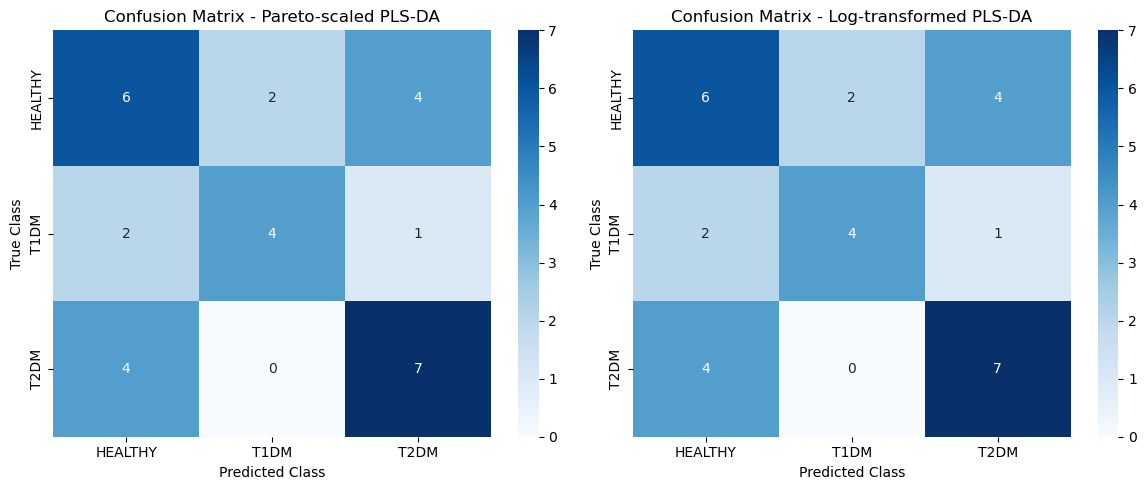

In [95]:

# Compute confusion matrices using cross-validated predictions for all samples
confusionPareto = confusion_matrix(classIndices, yPredClassCVPareto)
confusionLog = confusion_matrix(classIndices, yPredClassCVLog)

# Convert confusion matrices to percentages (row-normalised)
confusionParetoPct = confusionPareto / confusionPareto.sum(axis=1, keepdims=True) * 100
confusionLogPct = confusionLog / confusionLog.sum(axis=1, keepdims=True) * 100

# Plot confusion matrices for Pareto and Log
plt.figure(figsize=(12, 5))

# Pareto-scaled PLS-DA
plt.subplot(1, 2, 1)
sns.heatmap(
    confusionPareto,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=lb.classes_,
    yticklabels=lb.classes_
)
plt.title('Confusion Matrix - Pareto-scaled PLS-DA')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Log-transformed PLS-DA
plt.subplot(1, 2, 2)
sns.heatmap(
    confusionLog,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=lb.classes_,
    yticklabels=lb.classes_
)
plt.title('Confusion Matrix - Log-transformed PLS-DA')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.tight_layout()
plt.show()
plt.close()


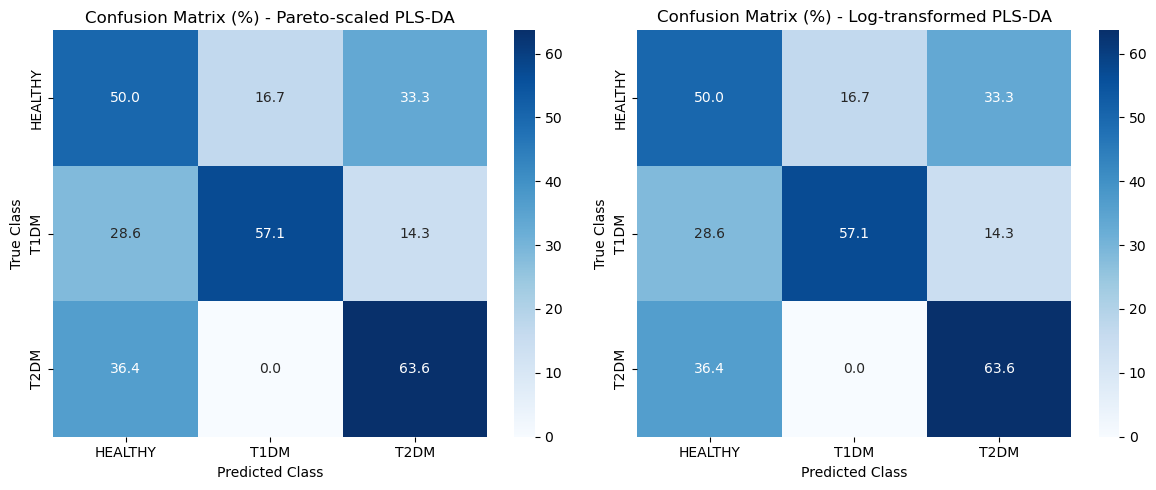

In [ ]:
# Plot confusion matrices as percentages for better interpretability

plt.figure(figsize=(12, 5))

# Pareto-scaled PLS-DA (percentages)
plt.subplot(1, 2, 1)
sns.heatmap(
    confusionParetoPct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_
)
plt.title("Confusion Matrix (%) - Pareto-scaled PLS-DA")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

# Log-transformed PLS-DA (percentages)
plt.subplot(1, 2, 2)
sns.heatmap(
    confusionLogPct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_
)
plt.title("Confusion Matrix (%) - Log-transformed PLS-DA")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.tight_layout()
plt.show()
plt.close()

Next step is too look at SHAP (SHapley Additive explanations), which is used for explaining the output of machine learning models by attributing the model's prediction to each feature in a way that fairly distributes the contribution among the features.

Next step is too look at Variable Importance in Projection (VIP) scores from the PLS-DA model which will tell us which lipids contribute the most to class separation across the latent variables?

Those which have a VIP Score >1.0 are important for discrimination and < 0.8 have low importance

This will be done using jupyter notebook with R kernel "mixOmics_JupyterNotebook_for_VIPscores"
